# Data Visualizations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
from glob import glob

def visualize_multiple_csvs_as_video(csv_folder, output_video_path='intersection.mp4', interval_ms=100, max_frames=None):
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        print("No CSV files found.")
        return

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Normalize track IDs to assign each car a unique color
    track_ids = df['TRACK_ID'].unique()
    colors = {track_id: plt.cm.tab20(i % 20) for i, track_id in enumerate(track_ids)}

    # Group by timestamp
    timestamps = sorted(df['TIMESTAMP'].unique())
    if max_frames is not None:
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    ax.set_aspect('equal')

    def init():
        return []

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_title(f"Time: {ts:.1f}s")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')

        road_width = 50
        ax.add_patch(plt.Rectangle((df['X'].min() - 20, -road_width / 2),
                                (df['X'].max() - df['X'].min()) + 40,
                                road_width, color='lightgray', zorder=0))
        ax.add_patch(plt.Rectangle((-road_width / 2, df['Y'].min() - 20),
                                road_width,
                                (df['Y'].max() - df['Y'].min()) + 40,
                                color='lightgray', zorder=0))

        if ts not in grouped.groups:
            return []

        frame_df = grouped.get_group(ts)

        # Draw vehicles
        for _, row in frame_df.iterrows():
            x = float(row['X'])
            y = float(row['Y'])
            track_id = row['TRACK_ID']
            yaw_deg = float(row['yaw'])
            speed = float(row['speed'])
            color = colors.get(track_id, 'gray')

            # Heading for arrow (correct as is)
            heading_arrow = np.deg2rad(yaw_deg + 90)

            # Vehicle rotation (flipped horizontally)
            heading_rect = -heading_arrow

            length = 4
            width = 2
            dx = -length / 2
            dy = -width / 2

            rect = plt.Rectangle((x + dx, y + dy), length, width,
                                color=color, zorder=1)
            transform = plt.matplotlib.transforms.Affine2D().rotate_around(x, y, heading_rect) + ax.transData
            rect.set_transform(transform)
            ax.add_patch(rect)

            arrow_length = min(speed * 0.4, 10)
            ax.arrow(x, y,
                    -arrow_length * np.cos(heading_arrow),
                    arrow_length * np.sin(heading_arrow),
                    head_width=0.7,
                    head_length=1.0,
                    fc='black',
                    ec='black',
                    zorder=2)

            ax.text(x, y + 2.5, str(track_id), fontsize=6, ha='center', zorder=3)

        return []


    ani = animation.FuncAnimation(fig, update, frames=len(timestamps), init_func=init, interval=interval_ms, blit=False)
    ani.save(output_video_path, writer='ffmpeg', fps=1000 // interval_ms)
    print(f"Video saved to {output_video_path}")


Video saved to simple_separate_10m_intersection.mp4


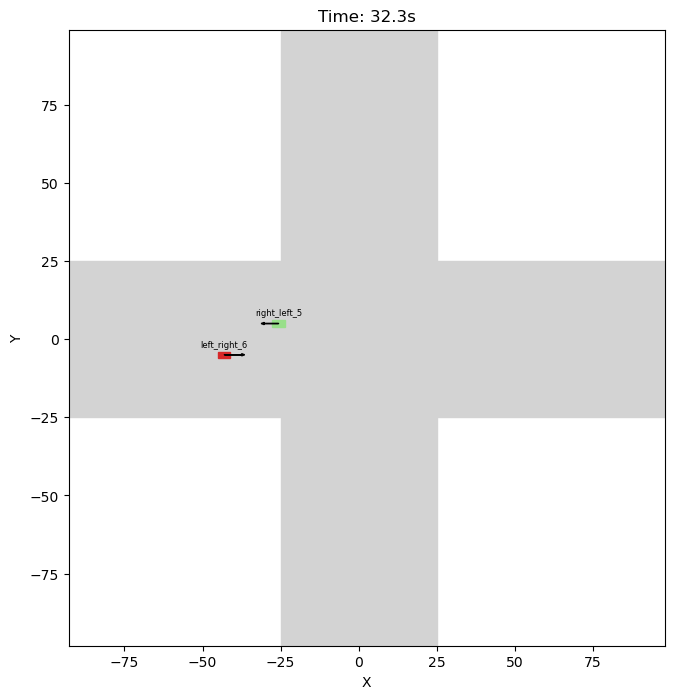

In [ ]:
path_to_csv_data = r'csv/train_1k_simple_separate_10m'
output_video_name = "simple_separate_10m_intersection.mp4"

visualize_multiple_csvs_as_video(
    csv_folder=path_to_csv_data,
    output_video_path=output_video_name,
    interval_ms=100,
    max_frames=250  # optional lenght of the video in frames (None for all frames)
)


## Test inference with the model and visualize

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os, math
from glob import glob
import torch
from model import GNN_mtl_gnn, GNN_mtl_mlp
from torch_geometric.data import Data
from tqdm import tqdm

/home/stud/vida/miniconda3/envs/MTP/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ──────────────────────────────
#  1.  helpers
# ─────────────────────────────

def rotation_matrix_back(yaw):
    """
    Rotate back.
    https://en.wikipedia.org/wiki/Rotation_matrix#Non-standard_orientation_of_the_coordinate_system
    """
    rotation = np.array([[np.cos(-np.pi/2+yaw), -np.sin(-np.pi/2+yaw)],[np.sin(-np.pi/2+yaw), np.cos(-np.pi/2+yaw)]])
    rotation = torch.tensor(rotation).float()
    return rotation

def build_data_for_track(track_rows, device):
    """
    track_rows: deque with dict-like rows.
    Creates Data.x  [num_vehicles, 7]  =  [X, Y, speed, yaw, int_left, int_right, int_straight]
    """
    # build intent flags from the first stored row
    tid = track_rows[0]['TRACK_ID']
    if 'left' in tid:
        intent = [1, 0, 0]
    elif 'right' in tid:
        intent = [0, 1, 0]
    else:
        intent = [0, 0, 1]

    feats = [[r['X'], r['Y'], r['speed'], r['yaw'], *intent] for r in track_rows]
    x = torch.tensor(feats, dtype=torch.float, device=device)
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)     # no graph edges here
    data = Data(x=x, edge_index=edge_index)
    # print(f"Data contains {data.x.shape[0]} frames for track {tid} with features: {data.x.shape[1]}")
    return data

def load_model(model_path, device, use_mlp=False, hidden_dim=128):
    """
    Load the model from the specified path.
    """
    cls = GNN_mtl_mlp if use_mlp else GNN_mtl_gnn
    model = cls(hidden_channels=hidden_dim).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

def update_angle(yaw, p1, p2, p3):
    """
    Update the angle using the tangent of the curve defined by three points.
    yaw: Current yaw angle in radians.
    p1: First point (previous position)
    p2: Second point (current predicted position)
    p3: Third point (next predicted position)

    returns: Updated yaw angle in radians.
    """
    v0 = np.subtract(p2, p1)
    v1 = np.subtract(p3, p2)
    angle = np.arctan2(v1[1], v1[0]) - np.arctan2(v0[1], v0[0])
    new_yaw = np.mod(yaw + angle, 2*np.pi)   # wraps in one line
    return new_yaw

In [23]:
p1 = (0, 0)
p2 = (1, 0)     # heading east
p3 = (1, 1)     # turn north
print(np.rad2deg(update_angle(0, p1, p2, p3)))  # → 90°

90.0


In [ ]:
# ──────────────────────────────
#  2.  main plotting function
# ──────────────────────────────

def visualize_with_prediction(
        csv_folder: str,
        model_path: str,
        output_video_path: str = 'simulation.mp4',
        device: str = 'cpu',
        interval_ms: int = 100,
        duration_sec: int = None,
        background_path: str = None,
        show_progress: bool = True):

    # ---------------- read data ----------------
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        raise FileNotFoundError(f"No CSV files found in {csv_folder}")

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Convert 'YAW' values from degrees to radians
    df['yaw'] = df['yaw'].apply(lambda x: np.deg2rad(x))

    timestamps = df['TIMESTAMP'].unique().tolist()
    if duration_sec is not None:
        max_frames = min(len(timestamps), int(duration_sec * 1000 / interval_ms))
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # ---------------- colours, limits ----------------
    track_ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(track_ids)}

    x_lo, x_hi = df['X'].min() - 10, df['X'].max() + 10
    y_lo, y_hi = df['Y'].min() - 10, df['Y'].max() + 10

    # optional background
    bg_img = plt.imread(background_path) if background_path else None

    # ---------------- model ----------------
    model = load_model(model_path, device=device, use_mlp=False, hidden_dim=128)

    # ---------------- figure ----------------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    last_track_position = dict()

    def init():
        return []

    def update(frame):
        # Set of track currently in the scene:

        ts = timestamps[frame]
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_title(f'Time: {ts:.2f} s')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        if bg_img is not None:
            ax.imshow(bg_img, extent=[x_lo, x_hi, y_lo, y_hi],
                      origin='lower', cmap='gray', alpha=.6)

        else:
            road_width = 50
            ax.add_patch(plt.Rectangle((x_lo - 20, -road_width / 2),
                                    (x_hi - x_lo) + 40,
                                    road_width, color='lightgray', zorder=0))
            ax.add_patch(plt.Rectangle((-road_width / 2, y_lo - 20),
                                    road_width,
                                    (y_hi - y_lo) + 40,
                                    color='lightgray', zorder=0))

        frame_df = grouped.get_group(ts)

        for _, row in frame_df.iterrows():
            track_id = row['TRACK_ID']
            color = colours[track_id]

            # If the track is new in the current frame, take the data from the dataframe
            if track_id not in last_track_position:
                last_track_position[track_id] = row

                ax.plot(row['X'], row['Y'], 'o', color=color, label=f'Track {track_id}')
                ax.text(row['X'], row['Y'] + 2.5, str(track_id), fontsize=6, ha='center', zorder=3) # This line adds the track ID above the car

            # If the track is already shown, just update its position using the model's prediction
            else:
                prev_row = last_track_position[track_id]
                with torch.no_grad():
                    data = build_data_for_track([prev_row], device=device)
                    out = model(data.x[:, [0, 1, 4, 5, 6]], data.edge_index) # [x, y, v, yaw, intention(3-bit)] -> [x, y, intention], edge_index = [edge, 2]
                    out = out.reshape(-1,30,2)  # [v, pred, 2]
                    out = out.permute(0,2,1)    # [v, 2, pred]

                    # Rotate back to global coordinates
                    yaw = data.x[:,3].detach().cpu().numpy()
                    rotations = torch.stack([rotation_matrix_back(yaw[i])  for i in range(data.x.shape[0])]).to(out.device)
                    out = torch.bmm(rotations, out).permute(0,2,1)       # [v, pred, 2]
                    out += data.x[:,[0,1]].unsqueeze(1)

                    x_pred, y_pred = out[0, 0].tolist()
                    ax.plot(x_pred, y_pred, 'o', color=color, label=f'Track {track_id} (predicted)')

                    # PLot the future predictions but with transparent color
                    future_color = (color[0], color[1], color[2], 0.2)  # Make the color semi-transparent
                    ax.plot(out[0, 1:, 0].cpu().numpy(), out[0, 1:, 1].cpu().numpy(),
                            'o', color=future_color, label=f'Track {track_id} (future)', alpha=0.2)
                    
                    p1 = (prev_row['X'], prev_row['Y']) # p1 is the previous position in the track
                    p2 = (x_pred, y_pred) # p2 is the current position in the predictions
                    p3 = (out[0, 1, 0].item(), out[0, 1, 1].item()) # p3 is the next point in the predictions

                    new_yaw = update_angle(prev_row['yaw'], p1, p2, p3)

                    # draw arrow with new_yaw
                    ax.arrow(x_pred, y_pred, 5*np.cos(new_yaw), 5*np.sin(new_yaw),
                            head_width=2, head_length=2, fc=color, ec=color)
                    
                     # Draw the heading rectangle (car body)
                    length = 4
                    width = 2
                    dx = -length / 2
                    dy = -width / 2
                    rect = plt.Rectangle((x_pred + dx, y_pred + dy), length, width,
                                         color=color, zorder=1)
                    transform = plt.matplotlib.transforms.Affine2D().rotate_around(
                        x_pred, y_pred, new_yaw) + ax.transData
                    rect.set_transform(transform)
                    ax.add_patch(rect)

                    # store the fresh state
                    last_track_position[track_id].update({'X': x_pred, 'Y': y_pred, 'yaw': new_yaw})

                    ax.text(x_pred, y_pred + 2.5, str(track_id), fontsize=6, ha='center', zorder=3) # This line adds the track ID above the car

        return []

    # ---------------- animation ----------------
    os.makedirs(os.path.dirname(output_video_path) or '.', exist_ok=True)

    ani = animation.FuncAnimation(
        fig, update, frames=len(timestamps),
        blit=False, interval=interval_ms, repeat=False)

    # ---------------- tqdm progress bar ----------------
    bar = tqdm(total=len(timestamps), disable=not show_progress,
               desc='Rendering frames')

    def _progress(frame_number, total):
        if frame_number > bar.n:
            bar.update(frame_number - bar.n)

    ani.save(output_video_path, writer='ffmpeg',
             fps=1000 // interval_ms, progress_callback=_progress)

    bar.close()
    print(f'Video saved to {output_video_path}')

Rendering frames: 100%|█████████▉| 199/200 [00:24<00:00,  8.07it/s]

Video saved to output/20250701_2106_animation_with_predictions_4.mp4


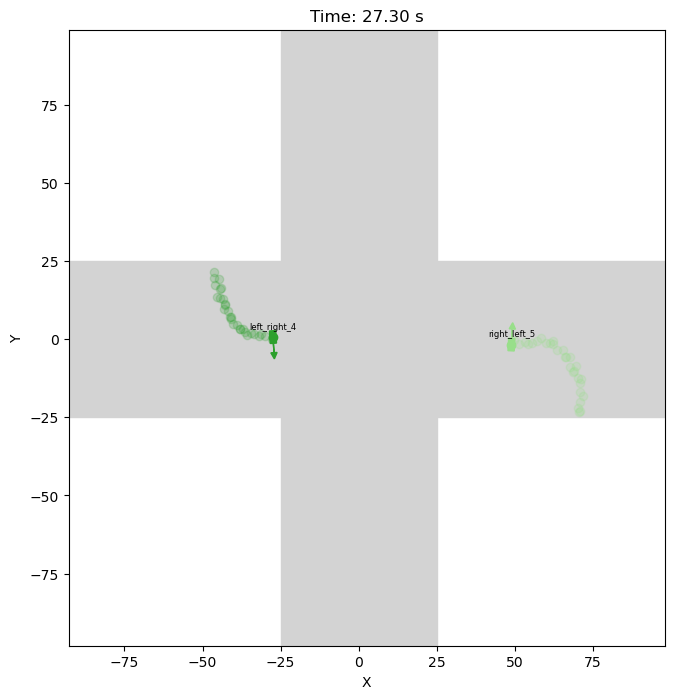

In [18]:
import datetime

# --- data and weights paths ---
csv_folder = 'csv/train_1k_simple_separate_10m'
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bg_img_path = 'simple_separate_10m_binary.png'
output_video_path = f'output/{datetime.datetime.now().strftime("%Y%m%d_%H%M")}_animation_with_predictions_4.mp4'

visualize_with_prediction(
    csv_folder=csv_folder,
    model_path=model_path,
    output_video_path=output_video_path,
    device=device,
    interval_ms=100,
    duration_sec=20,
    background_path=None,
    show_progress=True
)

In [5]:
# --- data and weights paths ---
csv_folder = 'csv/train_1k_simple_separate_10m'
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bg_img_path = 'simple_separate_10m_binary.png'
output_video_path = 'test' #'output/animation_with_predictions_4.mp4'

# ---------------- read data ----------------
all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

if not all_csvs:
    raise FileNotFoundError(f"No CSV files found in {csv_folder}")

df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
df = df.sort_values(by='TIMESTAMP')

timestamps = df['TIMESTAMP'].unique().tolist()

grouped = df.groupby('TIMESTAMP')

In [ ]:
import os, math
from glob import glob

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

# ──────────────────────────────
#  2.  main plotting function
# ──────────────────────────────
def visualize_with_prediction(
        csv_folder: str,
        model_path: str,
        output_video_path: str = 'simulation.mp4',
        device: str = 'cpu',
        interval_ms: int = 100,
        duration_sec: int = None,
        background_path: str = None,
        show_progress: bool = True):

    # ---------- read data ----------
    all_csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not all_csvs:
        raise FileNotFoundError(f'No CSV files in {csv_folder}')

    df = (pd
          .concat(pd.read_csv(f) for f in all_csvs)
          .sort_values('TIMESTAMP'))

    timestamps = df['TIMESTAMP'].unique().tolist()
    if duration_sec is not None:
        max_frames = min(len(timestamps),
                         int(duration_sec * 1000 / interval_ms))
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # ---------- colours & limits ----------
    track_ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(track_ids)}

    x_lo, x_hi = df['X'].min() - 10, df['X'].max() + 10
    y_lo, y_hi = df['Y'].min() - 10, df['Y'].max() + 10

    # ---------- background ----------
    bg_img = plt.imread(background_path) if background_path else None

    # ---------- model ----------
    model = GNN_mtl_gnn(hidden_channels=128).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ---------- figure ----------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    last_track = {}          # track_id → last row (mutated in-place)

    # ---------- update function ----------
    def update(frame_idx: int):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_title(f'Time: {ts:.2f} s')
        ax.set_xlabel('X'); ax.set_ylabel('Y')

        if bg_img is not None:
            ax.imshow(bg_img, extent=[x_lo, x_hi, y_lo, y_hi],
                      origin='lower', cmap='gray', alpha=.6)
        else:
            road_w = 50
            ax.add_patch(plt.Rectangle((x_lo - 20, -road_w/2),
                                       (x_hi - x_lo) + 40, road_w,
                                       color='lightgray', zorder=0))
            ax.add_patch(plt.Rectangle((-road_w/2, y_lo - 20),
                                       road_w, (y_hi - y_lo) + 40,
                                       color='lightgray', zorder=0))

        frame_df = grouped.get_group(ts)

        for _, now in frame_df.iterrows():
            tid   = now['TRACK_ID']
            color = colours[tid]

            # --- first time we see this car ---
            if tid not in last_track:
                last_track[tid] = now
                ax.plot(now['X'], now['Y'], 'o', color=color)
                ax.text(now['X'], now['Y']+2.5, tid, fontsize=6,
                        ha='center', zorder=3)
                continue

            # --- predict next position from model ---
            prev = last_track[tid]
            with torch.no_grad():
                data = build_data_for_track([prev], device=device)
                out  = model(data.x[:, [0, 1, 4, 5, 6]], data.edge_index)
                out  = (out.reshape(-1, 30, 2)
                            .permute(0, 2, 1))          # [1,2,30]

                yaw_rad = np.deg2rad(data.x[:, 3].cpu().numpy())
                R = torch.stack([rotation_matrix_back(a) for a in yaw_rad]
                                ).to(out.device)
                out = torch.bmm(R, out).permute(0, 2, 1)
                out += data.x[:, [0, 1]].unsqueeze(1)

                x_pred, y_pred = out[0, 0].tolist()

            # --- heading: direction of travel ---
            dx = x_pred - prev['X']
            dy = y_pred - prev['Y']
            yaw_next =  math.degrees(math.atan2(dy, dx) + yaw_rad[0])

            # --- draw & store ---
            ax.plot(x_pred, y_pred, 'o', color=color,
                    label=f'Track {tid} (pred)')
            ax.text(x_pred, y_pred + 2.5, tid, fontsize=6,
                    ha='center', zorder=3)

            new_row = prev.copy()
            new_row['X']   = x_pred
            new_row['Y']   = y_pred
            new_row['yaw'] = yaw_next
            last_track[tid] = new_row

        return []

    # ---------- animation ----------
    os.makedirs(os.path.dirname(output_video_path) or '.', exist_ok=True)

    ani = animation.FuncAnimation(
        fig, update, frames=len(timestamps),
        blit=False, interval=interval_ms, repeat=False)

    # ---------- tqdm ----------
    bar = tqdm(total=len(timestamps), disable=not show_progress,
               desc='Rendering frames')

    def _progress(frame_number, total):
        if frame_number > bar.n:
            bar.update(frame_number - bar.n)

    ani.save(output_video_path, writer='ffmpeg',
             fps=1000 // interval_ms, progress_callback=_progress)
    bar.close()
    print(f'Video saved to {output_video_path}')


Rendering frames: 100%|██████████| 350/350 [00:27<00:00, 12.72it/s]


Video saved to test.mp4


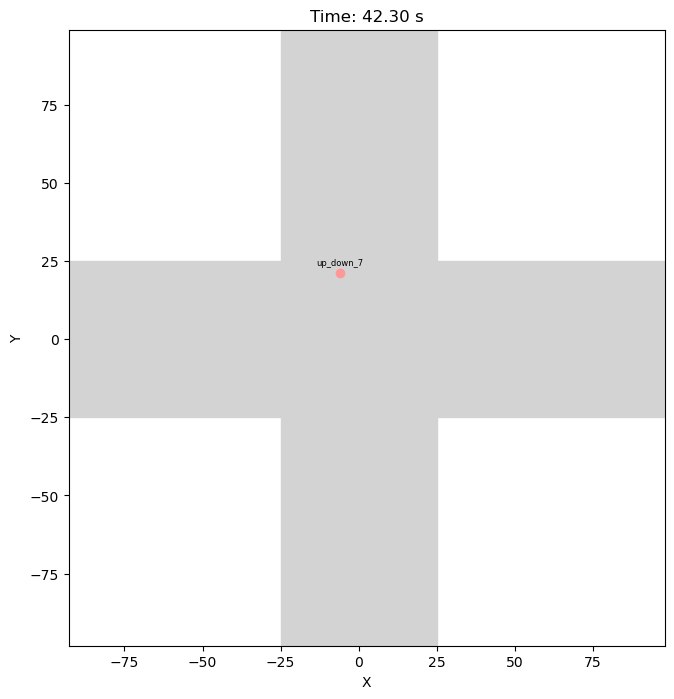

In [ ]:
# --- data and weights paths ---
csv_folder = 'csv/train_1k_simple_separate_10m'
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bg_img_path = 'simple_separate_10m_binary.png'
output_video_path = 'output/test.mp4' # 'output/animation_with_predictions_4.mp4'

visualize_with_prediction(
    csv_folder=csv_folder,
    model_path=model_path,
    output_video_path=output_video_path,
    device=device,
    interval_ms=100,
    duration_sec=35,
    background_path=None,
    show_progress=True
)

render:   0%|          | 1/200 [00:00<01:18,  2.54it/s]

DEBUG new down_up_1 at (5.00,-53.36)
DEBUG down_up_1 ts=7.40 prev=(5.00,-53.36) pred=(6.87,-54.38) next=(6.62,-54.61) yaw_ds_prev=0.00
DEBUG down_up_1 ts=7.50 prev=(6.87,-54.38) pred=(5.29,-55.86) next=(5.00,-55.58) yaw_ds_prev=4.38


render:   2%|▏         | 3/200 [00:00<00:33,  5.94it/s]

DEBUG down_up_1 ts=7.60 prev=(5.29,-55.86) pred=(3.79,-54.27) next=(4.17,-54.17) yaw_ds_prev=2.84
DEBUG down_up_1 ts=7.70 prev=(3.79,-54.27) pred=(5.84,-53.64) next=(5.78,-53.97) yaw_ds_prev=0.78
DEBUG down_up_1 ts=7.80 prev=(5.84,-53.64) pred=(5.41,-55.75) next=(5.06,-55.65) yaw_ds_prev=5.00


render:   2%|▎         | 5/200 [00:00<00:24,  7.89it/s]

DEBUG down_up_1 ts=7.90 prev=(5.41,-55.75) pred=(3.32,-55.11) next=(3.58,-54.82) yaw_ds_prev=3.35
DEBUG down_up_1 ts=8.00 prev=(3.32,-55.11) pred=(4.73,-53.46) next=(4.84,-53.77) yaw_ds_prev=1.34
DEBUG down_up_1 ts=8.10 prev=(4.73,-53.46) pred=(5.44,-55.47) next=(5.10,-55.45) yaw_ds_prev=5.55


render:   4%|▍         | 9/200 [00:01<00:19,  9.87it/s]

DEBUG down_up_1 ts=8.20 prev=(5.44,-55.47) pred=(3.26,-55.35) next=(3.43,-55.00) yaw_ds_prev=3.59
DEBUG down_up_1 ts=8.30 prev=(3.26,-55.35) pred=(4.17,-53.37) next=(4.36,-53.64) yaw_ds_prev=1.62
DEBUG down_up_1 ts=8.40 prev=(4.17,-53.37) pred=(5.39,-55.11) next=(5.07,-55.18) yaw_ds_prev=5.80


render:   6%|▌         | 11/200 [00:01<00:18, 10.33it/s]

DEBUG down_up_1 ts=8.50 prev=(5.39,-55.11) pred=(3.26,-55.55) next=(3.33,-55.17) yaw_ds_prev=3.85
DEBUG down_up_1 ts=8.60 prev=(3.26,-55.55) pred=(3.60,-53.39) next=(3.87,-53.61) yaw_ds_prev=1.89
DEBUG down_up_1 ts=8.70 prev=(3.60,-53.39) pred=(5.25,-54.77) next=(4.99,-54.91) yaw_ds_prev=6.06


render:   8%|▊         | 15/200 [00:01<00:17, 10.45it/s]

DEBUG down_up_1 ts=8.80 prev=(5.25,-54.77) pred=(3.34,-55.77) next=(3.31,-55.40) yaw_ds_prev=4.13
DEBUG down_up_1 ts=8.90 prev=(3.34,-55.77) pred=(3.11,-53.60) next=(3.42,-53.76) yaw_ds_prev=2.16
DEBUG down_up_1 ts=9.00 prev=(3.11,-53.60) pred=(5.05,-54.54) next=(4.86,-54.75) yaw_ds_prev=0.01


render:   8%|▊         | 17/200 [00:01<00:17, 10.70it/s]

DEBUG down_up_1 ts=9.10 prev=(5.05,-54.54) pred=(3.56,-56.09) next=(3.42,-55.75) yaw_ds_prev=4.45
DEBUG down_up_1 ts=9.20 prev=(3.56,-56.09) pred=(2.74,-54.07) next=(3.11,-54.15) yaw_ds_prev=2.44
DEBUG down_up_1 ts=9.30 prev=(2.74,-54.07) pred=(4.86,-54.51) next=(4.73,-54.76) yaw_ds_prev=0.25


render:  10%|█         | 21/200 [00:02<00:16, 11.00it/s]

DEBUG down_up_1 ts=9.40 prev=(4.86,-54.51) pred=(3.77,-56.36) next=(3.57,-56.05) yaw_ds_prev=4.68
DEBUG down_up_1 ts=9.50 prev=(3.77,-56.36) pred=(2.56,-54.54) next=(2.97,-54.57) yaw_ds_prev=2.64
DEBUG down_up_1 ts=9.60 prev=(2.56,-54.54) pred=(4.74,-54.62) next=(4.64,-54.88) yaw_ds_prev=0.43


render:  12%|█▏        | 23/200 [00:02<00:16, 10.43it/s]

DEBUG down_up_1 ts=9.70 prev=(4.74,-54.62) pred=(3.92,-56.60) next=(3.68,-56.31) yaw_ds_prev=4.82
DEBUG down_up_1 ts=9.80 prev=(3.92,-56.60) pred=(2.54,-54.90) next=(2.97,-54.90) yaw_ds_prev=2.75
DEBUG down_up_1 ts=9.90 prev=(2.54,-54.90) pred=(4.72,-54.84) next=(4.63,-55.12) yaw_ds_prev=0.49


render:  14%|█▎        | 27/200 [00:02<00:17, 10.02it/s]

DEBUG down_up_1 ts=10.00 prev=(4.72,-54.84) pred=(3.96,-56.86) next=(3.72,-56.56) yaw_ds_prev=4.85
DEBUG down_up_1 ts=10.10 prev=(3.96,-56.86) pred=(2.56,-55.18) next=(3.00,-55.18) yaw_ds_prev=2.77


render:  14%|█▍        | 29/200 [00:02<00:16, 10.30it/s]

DEBUG down_up_1 ts=10.20 prev=(2.56,-55.18) pred=(4.74,-55.10) next=(4.64,-55.38) yaw_ds_prev=0.50
DEBUG down_up_1 ts=10.30 prev=(4.74,-55.10) pred=(3.94,-57.10) next=(3.70,-56.79) yaw_ds_prev=4.83
DEBUG down_up_1 ts=10.40 prev=(3.94,-57.10) pred=(2.59,-55.37) next=(3.04,-55.39) yaw_ds_prev=2.73


render:  16%|█▌        | 31/200 [00:03<00:16, 10.53it/s]

DEBUG down_up_1 ts=10.50 prev=(2.59,-55.37) pred=(4.77,-55.40) next=(4.64,-55.68) yaw_ds_prev=0.45
DEBUG down_up_1 ts=10.60 prev=(4.77,-55.40) pred=(3.80,-57.33) next=(3.59,-56.99) yaw_ds_prev=4.75
DEBUG down_up_1 ts=10.70 prev=(3.80,-57.33) pred=(2.63,-55.46) next=(3.08,-55.54) yaw_ds_prev=2.62


render:  18%|█▊        | 35/200 [00:03<00:15, 10.90it/s]

DEBUG down_up_1 ts=10.80 prev=(2.63,-55.46) pred=(4.80,-55.75) next=(4.62,-56.02) yaw_ds_prev=0.33
DEBUG down_up_1 ts=10.90 prev=(4.80,-55.75) pred=(3.54,-57.52) next=(3.39,-57.14) yaw_ds_prev=4.60
DEBUG down_up_1 ts=11.00 prev=(3.54,-57.52) pred=(2.70,-55.48) next=(3.12,-55.62) yaw_ds_prev=2.46
DEBUG down_up_1 ts=11.00 prev=(2.70,-55.48) pred=(4.78,-56.12) next=(4.57,-56.36) yaw_ds_prev=0.17
DEBUG new down_left_2 at (5.00,-45.10)
DEBUG new up_down_0 at (-5.00,4.50)


render:  18%|█▊        | 37/200 [00:03<00:15, 10.22it/s]

DEBUG down_up_1 ts=11.10 prev=(4.78,-56.12) pred=(3.24,-57.65) next=(3.16,-57.24) yaw_ds_prev=4.43
DEBUG up_down_0 ts=11.10 prev=(-5.00,4.50) pred=(-5.37,4.77) next=(-5.65,3.94) yaw_ds_prev=3.14
DEBUG down_up_1 ts=11.10 prev=(3.24,-57.65) pred=(2.80,-55.49) next=(3.18,-55.70) yaw_ds_prev=2.26
DEBUG down_left_2 ts=11.10 prev=(5.00,-45.10) pred=(6.94,-45.94) next=(7.23,-46.21) yaw_ds_prev=0.00


render:  20%|█▉        | 39/200 [00:04<00:18,  8.53it/s]

DEBUG up_down_0 ts=11.20 prev=(-5.37,4.77) pred=(-5.53,4.37) next=(-4.68,4.39) yaw_ds_prev=5.02
DEBUG down_up_1 ts=11.20 prev=(2.80,-55.49) pred=(4.74,-56.50) next=(4.48,-56.69) yaw_ds_prev=6.27
DEBUG down_left_2 ts=11.20 prev=(6.94,-45.94) pred=(8.48,-47.39) next=(8.62,-47.83) yaw_ds_prev=5.95
DEBUG down_up_1 ts=11.20 prev=(4.74,-56.50) pred=(2.91,-57.69) next=(2.93,-57.26) yaw_ds_prev=4.23
DEBUG up_down_0 ts=11.30 prev=(-5.53,4.37) pred=(-5.11,4.35) next=(-5.47,5.15) yaw_ds_prev=0.70
DEBUG down_up_1 ts=11.30 prev=(2.91,-57.69) pred=(2.97,-55.49) next=(3.29,-55.75) yaw_ds_prev=2.03
DEBUG down_left_2 ts=11.30 prev=(8.48,-47.39) pred=(9.13,-49.43) next=(8.96,-49.94) yaw_ds_prev=5.44
DEBUG down_up_1 ts=11.30 prev=(2.97,-55.49) pred=(4.68,-56.85) next=(4.37,-56.97) yaw_ds_prev=6.08


render:  20%|██        | 41/200 [00:04<00:18,  8.62it/s]

DEBUG up_down_0 ts=11.40 prev=(-5.11,4.35) pred=(-5.33,4.75) next=(-5.91,4.08) yaw_ds_prev=2.74
DEBUG down_up_1 ts=11.40 prev=(4.68,-56.85) pred=(2.63,-57.61) next=(2.76,-57.18) yaw_ds_prev=4.00
DEBUG down_left_2 ts=11.40 prev=(9.13,-49.43) pred=(8.41,-51.49) next=(7.93,-51.73) yaw_ds_prev=4.80
DEBUG down_up_1 ts=11.40 prev=(2.63,-57.61) pred=(3.22,-55.48) next=(3.47,-55.80) yaw_ds_prev=1.78
DEBUG down_up_1 ts=11.50 prev=(3.22,-55.48) pred=(4.58,-57.19) next=(4.25,-57.23) yaw_ds_prev=5.86
DEBUG down_left_2 ts=11.50 prev=(8.41,-51.49) pred=(6.40,-52.48) next=(5.99,-52.29) yaw_ds_prev=4.04
DEBUG down_up_1 ts=11.50 prev=(4.58,-57.19) pred=(2.41,-57.43) next=(2.64,-57.05) yaw_ds_prev=3.76
DEBUG up_down_0 ts=11.50 prev=(-5.33,4.75) pred=(-5.62,4.42) next=(-4.82,4.13) yaw_ds_prev=4.66


render:  22%|██▏       | 43/200 [00:04<00:19,  8.06it/s]

DEBUG up_down_0 ts=11.60 prev=(-5.62,4.42) pred=(-5.25,4.25) next=(-5.29,5.11) yaw_ds_prev=0.33
DEBUG down_up_1 ts=11.60 prev=(2.41,-57.43) pred=(3.50,-55.51) next=(3.68,-55.85) yaw_ds_prev=1.53
DEBUG down_left_2 ts=11.60 prev=(6.40,-52.48) pred=(4.35,-51.52) next=(4.26,-51.21) yaw_ds_prev=3.16
DEBUG down_up_1 ts=11.60 prev=(3.50,-55.51) pred=(4.50,-57.44) next=(4.14,-57.41) yaw_ds_prev=5.67
DEBUG down_left_2 ts=11.70 prev=(4.35,-51.52) pred=(3.70,-49.35) next=(3.83,-49.13) yaw_ds_prev=2.29
DEBUG down_up_1 ts=11.70 prev=(4.50,-57.44) pred=(2.32,-57.20) next=(2.64,-56.87) yaw_ds_prev=3.53
DEBUG up_down_0 ts=11.70 prev=(-5.25,4.25) pred=(-5.30,4.69) next=(-6.08,4.25) yaw_ds_prev=2.40
DEBUG down_up_1 ts=11.70 prev=(2.32,-57.20) pred=(3.84,-55.59) next=(3.94,-55.95) yaw_ds_prev=1.28


render:  22%|██▎       | 45/200 [00:04<00:19,  7.94it/s]

DEBUG down_left_2 ts=11.80 prev=(3.70,-49.35) pred=(4.79,-47.42) next=(5.06,-47.28) yaw_ds_prev=1.47
DEBUG down_up_1 ts=11.80 prev=(3.84,-55.59) pred=(4.38,-57.69) next=(4.02,-57.56) yaw_ds_prev=5.45
DEBUG up_down_0 ts=11.80 prev=(-5.30,4.69) pred=(-5.68,4.47) next=(-5.00,3.94) yaw_ds_prev=4.35
DEBUG down_up_1 ts=11.80 prev=(4.38,-57.69) pred=(2.33,-56.90) next=(2.73,-56.67) yaw_ds_prev=3.27
DEBUG up_down_0 ts=11.90 prev=(-5.68,4.47) pred=(-5.38,4.19) next=(-5.17,5.02) yaw_ds_prev=0.01
DEBUG down_up_1 ts=11.90 prev=(2.33,-56.90) pred=(4.21,-55.75) next=(4.22,-56.11) yaw_ds_prev=1.02
DEBUG down_left_2 ts=11.90 prev=(4.79,-47.42) pred=(6.71,-46.44) next=(7.02,-46.45) yaw_ds_prev=0.90
DEBUG down_up_1 ts=11.90 prev=(4.21,-55.75) pred=(4.21,-57.92) next=(3.88,-57.71) yaw_ds_prev=5.20


render:  24%|██▎       | 47/200 [00:05<00:18,  8.21it/s]

DEBUG down_up_1 ts=12.00 prev=(4.21,-57.92) pred=(2.39,-56.67) next=(2.85,-56.56) yaw_ds_prev=3.04
DEBUG down_left_2 ts=12.00 prev=(6.71,-46.44) pred=(8.82,-46.54) next=(9.19,-46.78) yaw_ds_prev=0.37
DEBUG down_up_1 ts=12.00 prev=(2.39,-56.67) pred=(4.50,-56.07) next=(4.42,-56.41) yaw_ds_prev=0.75
DEBUG up_down_0 ts=12.00 prev=(-5.38,4.19) pred=(-5.30,4.61) next=(-6.17,4.41) yaw_ds_prev=2.10
DEBUG down_up_1 ts=12.10 prev=(4.50,-56.07) pred=(3.93,-58.16) next=(3.67,-57.84) yaw_ds_prev=4.95
DEBUG up_down_0 ts=12.10 prev=(-5.30,4.61) pred=(-5.72,4.49) next=(-5.19,3.81) yaw_ds_prev=4.10
DEBUG down_up_1 ts=12.10 prev=(3.93,-58.16) pred=(2.51,-56.47) next=(3.00,-56.50) yaw_ds_prev=2.77
DEBUG down_left_2 ts=12.10 prev=(8.82,-46.54) pred=(10.61,-47.70) next=(10.85,-48.25) yaw_ds_prev=6.12


render:  24%|██▍       | 49/200 [00:05<00:18,  8.32it/s]

DEBUG down_left_2 ts=12.20 prev=(10.61,-47.70) pred=(11.48,-49.68) next=(11.33,-50.37) yaw_ds_prev=5.53
DEBUG up_down_0 ts=12.20 prev=(-5.72,4.49) pred=(-5.51,4.15) next=(-5.10,4.90) yaw_ds_prev=6.05
DEBUG down_up_1 ts=12.20 prev=(2.51,-56.47) pred=(4.71,-56.55) next=(4.53,-56.85) yaw_ds_prev=0.43
DEBUG down_up_1 ts=12.20 prev=(4.71,-56.55) pred=(3.50,-58.37) next=(3.35,-57.96) yaw_ds_prev=4.63
DEBUG down_left_2 ts=12.30 prev=(11.48,-49.68) pred=(10.98,-51.82) next=(10.40,-52.23) yaw_ds_prev=4.90
DEBUG up_down_0 ts=12.30 prev=(-5.51,4.15) pred=(-5.31,4.53) next=(-6.20,4.53) yaw_ds_prev=1.86
DEBUG down_up_1 ts=12.30 prev=(3.50,-58.37) pred=(2.73,-56.29) next=(3.17,-56.48) yaw_ds_prev=2.43
DEBUG down_up_1 ts=12.30 prev=(2.73,-56.29) pred=(4.77,-57.09) next=(4.49,-57.31) yaw_ds_prev=0.10


render:  26%|██▌       | 51/200 [00:05<00:17,  8.50it/s]

DEBUG down_up_1 ts=12.40 prev=(4.77,-57.09) pred=(2.98,-58.36) next=(2.99,-57.91) yaw_ds_prev=4.27
DEBUG down_left_2 ts=12.40 prev=(10.98,-51.82) pred=(9.13,-53.07) next=(8.52,-52.91) yaw_ds_prev=4.16
DEBUG down_up_1 ts=12.40 prev=(2.98,-58.36) pred=(3.01,-56.15) next=(3.35,-56.45) yaw_ds_prev=2.04
DEBUG up_down_0 ts=12.40 prev=(-5.31,4.53) pred=(-5.75,4.50) next=(-5.36,3.72) yaw_ds_prev=3.90
DEBUG down_left_2 ts=12.50 prev=(9.13,-53.07) pred=(6.94,-52.45) next=(6.80,-51.99) yaw_ds_prev=3.31
DEBUG down_up_1 ts=12.50 prev=(3.01,-56.15) pred=(4.68,-57.57) next=(4.34,-57.68) yaw_ds_prev=6.05
DEBUG up_down_0 ts=12.50 prev=(-5.75,4.50) pred=(-5.61,4.12) next=(-5.07,4.79) yaw_ds_prev=5.86


render:  26%|██▌       | 52/200 [00:05<00:17,  8.40it/s]

DEBUG down_up_1 ts=12.60 prev=(4.68,-57.57) pred=(2.56,-58.15) next=(2.75,-57.73) yaw_ds_prev=3.92
DEBUG up_down_0 ts=12.60 prev=(-5.61,4.12) pred=(-5.34,4.47) next=(-6.22,4.62) yaw_ds_prev=1.69
DEBUG down_left_2 ts=12.60 prev=(6.94,-52.45) pred=(6.26,-50.28) next=(6.45,-49.99) yaw_ds_prev=2.33
DEBUG down_left_2 ts=12.70 prev=(6.26,-50.28) pred=(7.44,-48.41) next=(7.77,-48.29) yaw_ds_prev=1.45
DEBUG down_up_1 ts=12.70 prev=(2.56,-58.15) pred=(3.39,-56.11) next=(3.61,-56.47) yaw_ds_prev=1.67
DEBUG up_down_0 ts=12.70 prev=(-5.34,4.47) pred=(-5.77,4.51) next=(-5.52,3.68) yaw_ds_prev=3.74


render:  27%|██▋       | 54/200 [00:05<00:21,  6.94it/s]

DEBUG down_left_2 ts=12.80 prev=(7.44,-48.41) pred=(9.48,-47.69) next=(9.90,-47.83) yaw_ds_prev=0.77
DEBUG down_up_1 ts=12.80 prev=(3.39,-56.11) pred=(4.51,-57.98) next=(4.14,-57.96) yaw_ds_prev=5.74
DEBUG up_down_0 ts=12.80 prev=(-5.77,4.51) pred=(-5.69,4.12) next=(-5.07,4.70) yaw_ds_prev=5.71
DEBUG up_down_0 ts=12.90 prev=(-5.69,4.12) pred=(-5.38,4.42) next=(-6.22,4.69) yaw_ds_prev=1.55


render:  28%|██▊       | 56/200 [00:06<00:19,  7.35it/s]

DEBUG down_left_2 ts=12.90 prev=(9.48,-47.69) pred=(11.53,-48.36) next=(11.89,-48.87) yaw_ds_prev=0.10
DEBUG down_up_1 ts=12.90 prev=(4.51,-57.98) pred=(2.32,-57.79) next=(2.65,-57.45) yaw_ds_prev=3.56
DEBUG down_up_1 ts=13.00 prev=(2.32,-57.79) pred=(3.83,-56.18) next=(3.92,-56.57) yaw_ds_prev=1.29
DEBUG up_down_0 ts=13.00 prev=(-5.38,4.42) pred=(-5.80,4.52) next=(-5.65,3.66) yaw_ds_prev=3.61
DEBUG down_left_2 ts=13.00 prev=(11.53,-48.36) pred=(12.82,-50.12) next=(12.79,-50.86) yaw_ds_prev=5.75


render:  29%|██▉       | 58/200 [00:06<00:18,  7.84it/s]

DEBUG down_left_2 ts=13.10 prev=(12.82,-50.12) pred=(12.72,-52.33) next=(12.17,-52.86) yaw_ds_prev=5.07
DEBUG down_up_1 ts=13.10 prev=(3.83,-56.18) pred=(4.29,-58.32) next=(3.92,-58.15) yaw_ds_prev=5.41
DEBUG up_down_0 ts=13.10 prev=(-5.80,4.52) pred=(-5.77,4.12) next=(-5.08,4.63) yaw_ds_prev=5.60
DEBUG down_left_2 ts=13.20 prev=(12.72,-52.33) pred=(11.09,-53.87) next=(10.38,-53.79) yaw_ds_prev=4.31
DEBUG down_up_1 ts=13.20 prev=(4.29,-58.32) pred=(2.29,-57.35) next=(2.74,-57.17) yaw_ds_prev=3.20
DEBUG up_down_0 ts=13.20 prev=(-5.77,4.12) pred=(-5.43,4.38) next=(-6.23,4.74) yaw_ds_prev=1.45


render:  30%|██▉       | 59/200 [00:06<00:19,  7.12it/s]

DEBUG down_left_2 ts=13.30 prev=(11.09,-53.87) pred=(8.83,-53.57) next=(8.55,-53.03) yaw_ds_prev=3.45
DEBUG down_up_1 ts=13.30 prev=(2.29,-57.35) pred=(4.30,-56.44) next=(4.25,-56.82) yaw_ds_prev=0.90
DEBUG up_down_0 ts=13.30 prev=(-5.43,4.38) pred=(-5.83,4.53) next=(-5.75,3.66) yaw_ds_prev=3.52
DEBUG down_up_1 ts=13.40 prev=(4.30,-56.44) pred=(3.96,-58.60) next=(3.67,-58.30) yaw_ds_prev=5.05
DEBUG up_down_0 ts=13.40 prev=(-5.83,4.53) pred=(-5.83,4.13) next=(-5.11,4.58) yaw_ds_prev=5.52
DEBUG down_left_2 ts=13.40 prev=(8.83,-53.57) pred=(7.80,-51.53) next=(8.03,-51.13) yaw_ds_prev=2.49


render:  31%|███       | 62/200 [00:07<00:17,  7.94it/s]

DEBUG down_left_2 ts=13.50 prev=(7.80,-51.53) pred=(8.90,-49.59) next=(9.30,-49.51) yaw_ds_prev=1.50
DEBUG down_up_1 ts=13.50 prev=(3.96,-58.60) pred=(2.42,-57.01) next=(2.93,-57.02) yaw_ds_prev=2.85
DEBUG up_down_0 ts=13.50 prev=(-5.83,4.13) pred=(-5.47,4.37) next=(-6.24,4.78) yaw_ds_prev=1.37
DEBUG down_left_2 ts=13.60 prev=(8.90,-49.59) pred=(11.03,-49.16) next=(11.46,-49.44) yaw_ds_prev=0.63
DEBUG down_up_1 ts=13.60 prev=(2.42,-57.01) pred=(4.62,-56.98) next=(4.44,-57.29) yaw_ds_prev=0.49
DEBUG up_down_0 ts=13.60 prev=(-5.47,4.37) pred=(-5.86,4.54) next=(-5.84,3.67) yaw_ds_prev=3.45


render:  32%|███▏      | 64/200 [00:07<00:16,  8.31it/s]

DEBUG down_left_2 ts=13.70 prev=(11.03,-49.16) pred=(12.89,-50.33) next=(13.10,-50.99) yaw_ds_prev=6.13
DEBUG down_up_1 ts=13.70 prev=(4.62,-56.98) pred=(3.47,-58.83) next=(3.31,-58.42) yaw_ds_prev=4.66
DEBUG up_down_0 ts=13.70 prev=(-5.86,4.54) pred=(-5.88,4.15) next=(-5.14,4.56) yaw_ds_prev=5.47
DEBUG up_down_0 ts=13.80 prev=(-5.88,4.15) pred=(-5.51,4.36) next=(-6.27,4.80) yaw_ds_prev=1.33
DEBUG down_up_1 ts=13.80 prev=(3.47,-58.83) pred=(2.67,-56.77) next=(3.13,-56.96) yaw_ds_prev=2.44
DEBUG down_left_2 ts=13.80 prev=(12.89,-50.33) pred=(13.58,-52.43) next=(13.25,-53.12) yaw_ds_prev=5.43


render:  33%|███▎      | 66/200 [00:07<00:16,  8.24it/s]

DEBUG down_left_2 ts=13.90 prev=(13.58,-52.43) pred=(12.59,-54.46) next=(11.85,-54.66) yaw_ds_prev=4.67
DEBUG down_up_1 ts=13.90 prev=(2.67,-56.77) pred=(4.71,-57.57) next=(4.41,-57.78) yaw_ds_prev=0.10
DEBUG up_down_0 ts=13.90 prev=(-5.51,4.36) pred=(-5.89,4.55) next=(-5.89,3.67) yaw_ds_prev=3.43
DEBUG down_left_2 ts=14.00 prev=(12.59,-54.46) pred=(10.36,-55.01) next=(9.84,-54.57) yaw_ds_prev=3.81
DEBUG down_up_1 ts=14.00 prev=(4.71,-57.57) pred=(2.88,-58.79) next=(2.92,-58.33) yaw_ds_prev=4.24
DEBUG up_down_0 ts=14.00 prev=(-5.89,4.55) pred=(-5.92,4.16) next=(-5.18,4.56) yaw_ds_prev=5.46


render:  34%|███▍      | 68/200 [00:07<00:16,  8.24it/s]

DEBUG up_down_0 ts=14.10 prev=(-5.92,4.16) pred=(-5.55,4.37) next=(-6.31,4.80) yaw_ds_prev=1.33
DEBUG down_up_1 ts=14.10 prev=(2.88,-58.79) pred=(3.03,-56.59) next=(3.36,-56.91) yaw_ds_prev=2.00
DEBUG down_left_2 ts=14.10 prev=(10.36,-55.01) pred=(8.64,-53.47) next=(8.75,-52.92) yaw_ds_prev=2.86
DEBUG down_left_2 ts=14.20 prev=(8.64,-53.47) pred=(9.07,-51.22) next=(9.49,-51.05) yaw_ds_prev=1.83
DEBUG down_up_1 ts=14.20 prev=(3.03,-56.59) pred=(4.61,-58.11) next=(4.24,-58.18) yaw_ds_prev=6.00
DEBUG up_down_0 ts=14.20 prev=(-5.55,4.37) pred=(-5.93,4.56) next=(-5.92,3.69) yaw_ds_prev=3.43


render:  35%|███▌      | 70/200 [00:07<00:15,  8.16it/s]

DEBUG down_left_2 ts=14.30 prev=(9.07,-51.22) pred=(11.11,-50.35) next=(11.56,-50.58) yaw_ds_prev=0.84
DEBUG down_up_1 ts=14.30 prev=(4.61,-58.11) pred=(2.43,-58.48) next=(2.67,-58.07) yaw_ds_prev=3.82
DEBUG up_down_0 ts=14.30 prev=(-5.93,4.56) pred=(-5.96,4.17) next=(-5.22,4.59) yaw_ds_prev=5.48
DEBUG down_up_1 ts=14.40 prev=(2.43,-58.48) pred=(3.50,-56.55) next=(3.67,-56.94) yaw_ds_prev=1.55
DEBUG up_down_0 ts=14.40 prev=(-5.96,4.17) pred=(-5.59,4.39) next=(-6.36,4.80) yaw_ds_prev=1.36
DEBUG down_left_2 ts=14.40 prev=(11.11,-50.35) pred=(13.10,-51.32) next=(13.33,-51.95) yaw_ds_prev=6.25


render:  36%|███▌      | 72/200 [00:08<00:16,  7.91it/s]

DEBUG up_down_0 ts=14.50 prev=(-5.59,4.39) pred=(-5.97,4.57) next=(-5.93,3.70) yaw_ds_prev=3.46
DEBUG new down_up_3 at (5.00,-42.42)
DEBUG down_left_2 ts=14.50 prev=(13.10,-51.32) pred=(13.90,-53.40) next=(13.58,-54.08) yaw_ds_prev=5.49
DEBUG down_up_1 ts=14.50 prev=(3.50,-56.55) pred=(4.37,-58.56) next=(3.98,-58.46) yaw_ds_prev=5.61
DEBUG down_left_2 ts=14.50 prev=(13.90,-53.40) pred=(12.92,-55.45) next=(12.18,-55.63) yaw_ds_prev=4.68
DEBUG up_down_0 ts=14.60 prev=(-5.97,4.57) pred=(-5.98,4.18) next=(-5.27,4.63) yaw_ds_prev=5.52
DEBUG down_left_2 ts=14.60 prev=(12.92,-55.45) pred=(10.65,-55.96) next=(10.14,-55.48) yaw_ds_prev=3.79
DEBUG down_up_3 ts=14.60 prev=(5.00,-42.42) pred=(6.85,-43.21) next=(7.20,-43.56) yaw_ds_prev=0.00
DEBUG down_left_2 ts=14.60 prev=(10.65,-55.96) pred=(8.99,-54.31) next=(9.13,-53.76) yaw_ds_prev=2.81
DEBUG down_up_1 ts=14.60 prev=(4.37,-58.56) pred=(2.22,-57.99) next=(2.63,-57.72) yaw_ds_prev=3.39


render:  37%|███▋      | 74/200 [00:08<00:16,  7.62it/s]

DEBUG down_left_2 ts=14.70 prev=(8.99,-54.31) pred=(9.58,-52.09) next=(10.03,-51.96) yaw_ds_prev=1.77
DEBUG down_up_1 ts=14.70 prev=(2.22,-57.99) pred=(4.03,-56.71) next=(4.04,-57.11) yaw_ds_prev=1.09
DEBUG up_down_0 ts=14.70 prev=(-5.98,4.18) pred=(-5.63,4.41) next=(-6.42,4.79) yaw_ds_prev=1.41
DEBUG down_left_2 ts=14.70 prev=(9.58,-52.09) pred=(11.73,-51.46) next=(12.16,-51.77) yaw_ds_prev=0.72
DEBUG down_up_3 ts=14.70 prev=(6.85,-43.21) pred=(8.26,-44.61) next=(8.40,-45.12) yaw_ds_prev=5.91
DEBUG down_left_2 ts=14.80 prev=(11.73,-51.46) pred=(13.56,-52.72) next=(13.66,-53.39) yaw_ds_prev=6.10
DEBUG down_up_1 ts=14.80 prev=(4.03,-56.71) pred=(4.06,-58.90) next=(3.72,-58.63) yaw_ds_prev=5.22
DEBUG up_down_0 ts=14.80 prev=(-5.63,4.41) pred=(-6.01,4.57) next=(-5.92,3.71) yaw_ds_prev=3.52
DEBUG down_left_2 ts=14.80 prev=(13.56,-52.72) pred=(13.90,-54.96) next=(13.41,-55.53) yaw_ds_prev=5.27
DEBUG down_up_3 ts=14.80 prev=(8.26,-44.61) pred=(8.77,-46.50) next=(8.53,-46.96) yaw_ds_prev=5.39

render:  38%|███▊      | 75/200 [00:08<00:19,  6.45it/s]

DEBUG up_down_0 ts=14.90 prev=(-6.01,4.57) pred=(-6.00,4.19) next=(-5.32,4.69) yaw_ds_prev=5.59
DEBUG down_up_3 ts=14.90 prev=(8.77,-46.50) pred=(7.84,-48.24) next=(7.35,-48.34) yaw_ds_prev=4.66
DEBUG down_up_1 ts=14.90 prev=(4.06,-58.90) pred=(2.32,-57.52) next=(2.83,-57.46) yaw_ds_prev=2.98
DEBUG down_left_2 ts=14.90 prev=(13.90,-54.96) pred=(12.38,-56.70) next=(11.63,-56.63) yaw_ds_prev=4.41
DEBUG down_left_2 ts=14.90 prev=(12.38,-56.70) pred=(10.04,-56.44) next=(9.75,-55.84) yaw_ds_prev=3.47


render:  38%|███▊      | 77/200 [00:08<00:17,  7.07it/s]

DEBUG down_left_2 ts=15.00 prev=(10.04,-56.44) pred=(9.05,-54.30) next=(9.38,-53.88) yaw_ds_prev=2.46
DEBUG down_up_3 ts=15.00 prev=(7.84,-48.24) pred=(5.85,-48.59) next=(5.54,-48.27) yaw_ds_prev=3.76
DEBUG up_down_0 ts=15.00 prev=(-6.00,4.19) pred=(-5.67,4.45) next=(-6.48,4.76) yaw_ds_prev=1.49
DEBUG down_left_2 ts=15.00 prev=(9.05,-54.30) pred=(10.49,-52.49) next=(10.95,-52.56) yaw_ds_prev=1.35
DEBUG down_up_1 ts=15.00 prev=(2.32,-57.52) pred=(4.50,-57.18) next=(4.35,-57.53) yaw_ds_prev=0.63
DEBUG down_up_3 ts=15.10 prev=(5.85,-48.59) pred=(4.42,-47.09) next=(4.50,-46.76) yaw_ds_prev=2.79
DEBUG down_left_2 ts=15.10 prev=(10.49,-52.49) pred=(12.72,-52.78) next=(13.02,-53.28) yaw_ds_prev=0.31
DEBUG up_down_0 ts=15.10 prev=(-5.67,4.45) pred=(-6.06,4.58) next=(-5.90,3.73) yaw_ds_prev=3.60
DEBUG down_left_2 ts=15.10 prev=(12.72,-52.78) pred=(13.93,-54.68) next=(13.70,-55.35) yaw_ds_prev=5.70
DEBUG down_up_1 ts=15.10 prev=(4.50,-57.18) pred=(3.56,-59.16) next=(3.36,-58.76) yaw_ds_prev=4.77

render:  40%|███▉      | 79/200 [00:09<00:15,  7.57it/s]

DEBUG up_down_0 ts=15.20 prev=(-6.06,4.58) pred=(-6.01,4.19) next=(-5.38,4.76) yaw_ds_prev=5.68
DEBUG down_up_1 ts=15.20 prev=(3.56,-59.16) pred=(2.56,-57.17) next=(3.05,-57.33) yaw_ds_prev=2.54
DEBUG down_left_2 ts=15.20 prev=(13.93,-54.68) pred=(13.21,-56.87) next=(12.49,-57.11) yaw_ds_prev=4.81
DEBUG down_up_3 ts=15.20 prev=(4.42,-47.09) pred=(4.91,-45.11) next=(5.15,-45.01) yaw_ds_prev=1.78
DEBUG down_left_2 ts=15.20 prev=(13.21,-56.87) pred=(10.96,-57.59) next=(10.41,-57.14) yaw_ds_prev=3.88
DEBUG up_down_0 ts=15.30 prev=(-6.01,4.19) pred=(-5.71,4.48) next=(-6.55,4.71) yaw_ds_prev=1.59
DEBUG down_left_2 ts=15.30 prev=(10.96,-57.59) pred=(9.15,-56.03) next=(9.28,-55.46) yaw_ds_prev=2.88
DEBUG down_left_2 ts=15.30 prev=(9.15,-56.03) pred=(9.68,-53.74) next=(10.13,-53.63) yaw_ds_prev=1.80
DEBUG down_up_3 ts=15.30 prev=(4.91,-45.11) pred=(6.79,-44.32) next=(7.16,-44.39) yaw_ds_prev=0.82
DEBUG down_up_1 ts=15.30 prev=(2.56,-57.17) pred=(4.67,-57.80) next=(4.38,-58.04) yaw_ds_prev=0.19


render:  40%|████      | 81/200 [00:09<00:15,  7.76it/s]

DEBUG down_left_2 ts=15.40 prev=(9.68,-53.74) pred=(11.89,-53.17) next=(12.26,-53.52) yaw_ds_prev=0.70
DEBUG down_up_3 ts=15.40 prev=(6.79,-44.32) pred=(8.77,-44.65) next=(9.14,-44.98) yaw_ds_prev=0.25
DEBUG down_up_1 ts=15.40 prev=(4.67,-57.80) pred=(2.94,-59.16) next=(2.95,-58.69) yaw_ds_prev=4.32
DEBUG down_left_2 ts=15.40 prev=(11.89,-53.17) pred=(13.57,-54.67) next=(13.52,-55.33) yaw_ds_prev=5.99
DEBUG up_down_0 ts=15.40 prev=(-5.71,4.48) pred=(-6.10,4.58) next=(-5.85,3.76) yaw_ds_prev=3.70
DEBUG down_up_3 ts=15.50 prev=(8.77,-44.65) pred=(10.21,-45.94) next=(10.24,-46.48) yaw_ds_prev=5.97
DEBUG down_left_2 ts=15.50 prev=(13.57,-54.67) pred=(13.42,-56.97) next=(12.80,-57.36) yaw_ds_prev=5.07
DEBUG down_left_2 ts=15.50 prev=(13.42,-56.97) pred=(11.40,-58.22) next=(10.76,-57.91) yaw_ds_prev=4.12
DEBUG down_up_1 ts=15.50 prev=(2.94,-59.16) pred=(2.96,-56.95) next=(3.32,-57.28) yaw_ds_prev=2.05
DEBUG up_down_0 ts=15.50 prev=(-6.10,4.58) pred=(-6.02,4.20) next=(-5.46,4.84) yaw_ds_prev=

render:  42%|████▏     | 83/200 [00:09<00:14,  7.83it/s]

DEBUG down_up_3 ts=15.60 prev=(10.21,-45.94) pred=(10.32,-47.90) next=(9.89,-48.27) yaw_ds_prev=5.19
DEBUG down_left_2 ts=15.60 prev=(11.40,-58.22) pred=(9.26,-57.13) next=(9.25,-56.52) yaw_ds_prev=3.12
DEBUG down_up_1 ts=15.60 prev=(2.96,-56.95) pred=(4.59,-58.42) next=(4.21,-58.50) yaw_ds_prev=6.03
DEBUG down_left_2 ts=15.60 prev=(9.26,-57.13) pred=(9.27,-54.75) next=(9.70,-54.55) yaw_ds_prev=2.03
DEBUG up_down_0 ts=15.60 prev=(-6.02,4.20) pred=(-5.76,4.53) next=(-6.62,4.65) yaw_ds_prev=1.72
DEBUG down_left_2 ts=15.70 prev=(9.27,-54.75) pred=(11.37,-53.79) next=(11.76,-54.07) yaw_ds_prev=0.88
DEBUG down_up_1 ts=15.70 prev=(4.59,-58.42) pred=(2.42,-58.82) next=(2.66,-58.40) yaw_ds_prev=3.83
DEBUG up_down_0 ts=15.70 prev=(-5.76,4.53) pred=(-6.16,4.57) next=(-5.80,3.80) yaw_ds_prev=3.83
DEBUG down_left_2 ts=15.70 prev=(11.37,-53.79) pred=(13.21,-55.11) next=(13.21,-55.73) yaw_ds_prev=6.10
DEBUG down_up_3 ts=15.70 prev=(10.32,-47.90) pred=(8.79,-49.20) next=(8.27,-49.04) yaw_ds_prev=4.28

render:  42%|████▎     | 85/200 [00:09<00:14,  8.01it/s]

DEBUG down_left_2 ts=15.80 prev=(13.21,-55.11) pred=(13.23,-57.43) next=(12.64,-57.84) yaw_ds_prev=5.14
DEBUG down_left_2 ts=15.80 prev=(13.23,-57.43) pred=(11.27,-58.79) next=(10.62,-58.51) yaw_ds_prev=4.18
DEBUG down_up_1 ts=15.80 prev=(2.42,-58.82) pred=(3.48,-56.89) next=(3.66,-57.30) yaw_ds_prev=1.55
DEBUG up_down_0 ts=15.80 prev=(-6.16,4.57) pred=(-6.02,4.21) next=(-5.56,4.92) yaw_ds_prev=5.94
DEBUG down_up_3 ts=15.80 prev=(8.79,-49.20) pred=(6.85,-48.57) next=(6.74,-48.11) yaw_ds_prev=3.27
DEBUG down_up_3 ts=15.90 prev=(6.85,-48.57) pred=(6.38,-46.56) next=(6.65,-46.27) yaw_ds_prev=2.24
DEBUG up_down_0 ts=15.90 prev=(-6.02,4.21) pred=(-5.81,4.58) next=(-6.68,4.56) yaw_ds_prev=1.87
DEBUG down_left_2 ts=15.90 prev=(11.27,-58.79) pred=(9.06,-57.78) next=(9.04,-57.19) yaw_ds_prev=3.17
DEBUG down_up_1 ts=15.90 prev=(3.48,-56.89) pred=(4.33,-58.91) next=(3.94,-58.81) yaw_ds_prev=5.60
DEBUG down_left_2 ts=15.90 prev=(9.06,-57.78) pred=(9.01,-55.39) next=(9.43,-55.20) yaw_ds_prev=2.06


render:  43%|████▎     | 86/200 [00:10<00:13,  8.44it/s]

DEBUG down_left_2 ts=16.00 prev=(9.01,-55.39) pred=(11.13,-54.42) next=(11.50,-54.71) yaw_ds_prev=0.89
DEBUG down_up_3 ts=16.00 prev=(6.38,-46.56) pred=(7.74,-45.04) next=(8.15,-44.99) yaw_ds_prev=1.28
DEBUG down_left_2 ts=16.10 prev=(11.13,-54.42) pred=(12.97,-55.79) next=(12.94,-56.39) yaw_ds_prev=6.09
DEBUG down_up_3 ts=16.10 prev=(7.74,-45.04) pred=(9.70,-44.80) next=(10.11,-45.08) yaw_ds_prev=0.54
DEBUG down_left_2 ts=16.20 prev=(12.97,-55.79) pred=(12.88,-58.12) next=(12.28,-58.49) yaw_ds_prev=5.10
DEBUG down_up_3 ts=16.20 prev=(9.70,-44.80) pred=(11.30,-45.86) next=(11.37,-46.42) yaw_ds_prev=6.11


render:  45%|████▌     | 90/200 [00:10<00:11,  9.52it/s]

DEBUG down_up_3 ts=16.30 prev=(11.30,-45.86) pred=(11.54,-47.81) next=(11.10,-48.25) yaw_ds_prev=5.26
DEBUG down_left_2 ts=16.30 prev=(12.88,-58.12) pred=(10.82,-59.36) next=(10.22,-59.03) yaw_ds_prev=4.12
DEBUG down_left_2 ts=16.40 prev=(10.82,-59.36) pred=(8.70,-58.15) next=(8.76,-57.58) yaw_ds_prev=3.08
DEBUG down_up_3 ts=16.40 prev=(11.54,-47.81) pred=(10.12,-49.23) next=(9.52,-49.10) yaw_ds_prev=4.35
DEBUG down_left_2 ts=16.50 prev=(8.70,-58.15) pred=(8.98,-55.76) next=(9.41,-55.65) yaw_ds_prev=1.92


render:  46%|████▌     | 92/200 [00:10<00:11,  9.56it/s]

DEBUG down_up_3 ts=16.50 prev=(10.12,-49.23) pred=(8.11,-48.79) next=(7.95,-48.29) yaw_ds_prev=3.36
DEBUG down_left_2 ts=16.60 prev=(8.98,-55.76) pred=(11.24,-55.16) next=(11.55,-55.50) yaw_ds_prev=0.72
DEBUG down_up_3 ts=16.60 prev=(8.11,-48.79) pred=(7.52,-46.85) next=(7.81,-46.50) yaw_ds_prev=2.31


render:  47%|████▋     | 94/200 [00:10<00:11,  9.30it/s]

DEBUG down_up_3 ts=16.70 prev=(7.52,-46.85) pred=(8.81,-45.30) next=(9.26,-45.28) yaw_ds_prev=1.31
DEBUG down_left_2 ts=16.70 prev=(11.24,-55.16) pred=(12.81,-56.86) next=(12.65,-57.44) yaw_ds_prev=5.90
DEBUG down_up_3 ts=16.80 prev=(8.81,-45.30) pred=(10.75,-45.17) next=(11.13,-45.53) yaw_ds_prev=0.49
DEBUG down_left_2 ts=16.80 prev=(12.81,-56.86) pred=(12.22,-59.15) next=(11.57,-59.36) yaw_ds_prev=4.90


render:  48%|████▊     | 96/200 [00:11<00:12,  8.64it/s]

DEBUG down_left_2 ts=16.90 prev=(12.22,-59.15) pred=(9.90,-59.88) next=(9.44,-59.42) yaw_ds_prev=3.89
DEBUG down_up_3 ts=16.90 prev=(10.75,-45.17) pred=(12.16,-46.50) next=(12.13,-47.11) yaw_ds_prev=5.95
DEBUG down_left_2 ts=17.00 prev=(9.90,-59.88) pred=(8.21,-58.10) next=(8.45,-57.64) yaw_ds_prev=2.80
DEBUG down_up_3 ts=17.00 prev=(12.16,-46.50) pred=(12.05,-48.48) next=(11.51,-48.85) yaw_ds_prev=5.07


render:  49%|████▉     | 98/200 [00:11<00:11,  8.94it/s]

DEBUG down_left_2 ts=17.10 prev=(8.21,-58.10) pred=(9.32,-55.97) next=(9.73,-56.01) yaw_ds_prev=1.56
DEBUG down_up_3 ts=17.10 prev=(12.05,-48.48) pred=(10.35,-49.60) next=(9.77,-49.34) yaw_ds_prev=4.15
DEBUG down_left_2 ts=17.20 prev=(9.32,-55.97) pred=(11.65,-56.22) next=(11.82,-56.68) yaw_ds_prev=0.35
DEBUG down_up_3 ts=17.20 prev=(10.35,-49.60) pred=(8.48,-48.74) next=(8.44,-48.20) yaw_ds_prev=3.15


render:  50%|█████     | 100/200 [00:11<00:10,  9.22it/s]

DEBUG down_up_3 ts=17.30 prev=(8.48,-48.74) pred=(8.36,-46.71) next=(8.73,-46.44) yaw_ds_prev=2.07
DEBUG down_left_2 ts=17.30 prev=(11.65,-56.22) pred=(12.50,-58.41) next=(12.13,-58.91) yaw_ds_prev=5.53
DEBUG down_left_2 ts=17.40 prev=(12.50,-58.41) pred=(11.06,-60.34) next=(10.39,-60.25) yaw_ds_prev=4.51
DEBUG down_up_3 ts=17.40 prev=(8.36,-46.71) pred=(9.94,-45.52) next=(10.41,-45.64) yaw_ds_prev=1.08


render:  51%|█████     | 102/200 [00:11<00:10,  9.29it/s]

DEBUG down_left_2 ts=17.50 prev=(11.06,-60.34) pred=(8.62,-59.96) next=(8.48,-59.39) yaw_ds_prev=3.45
DEBUG down_up_3 ts=17.50 prev=(9.94,-45.52) pred=(11.83,-45.97) next=(12.08,-46.48) yaw_ds_prev=0.19
DEBUG down_left_2 ts=17.60 prev=(8.62,-59.96) pred=(8.04,-57.57) next=(8.42,-57.36) yaw_ds_prev=2.28
DEBUG down_up_3 ts=17.60 prev=(11.83,-45.97) pred=(12.70,-47.74) next=(12.42,-48.33) yaw_ds_prev=5.58


render:  52%|█████▏    | 104/200 [00:12<00:10,  9.48it/s]

DEBUG down_up_3 ts=17.70 prev=(12.70,-47.74) pred=(11.83,-49.56) next=(11.17,-49.68) yaw_ds_prev=4.69
DEBUG down_left_2 ts=17.70 prev=(8.04,-57.57) pred=(10.11,-56.37) next=(10.43,-56.62) yaw_ds_prev=0.99
DEBUG down_left_2 ts=17.80 prev=(10.11,-56.37) pred=(11.99,-57.80) next=(11.90,-58.32) yaw_ds_prev=6.09
DEBUG down_up_3 ts=17.80 prev=(11.83,-49.56) pred=(9.80,-49.88) next=(9.41,-49.40) yaw_ds_prev=3.73


render:  53%|█████▎    | 106/200 [00:12<00:09,  9.65it/s]

DEBUG down_left_2 ts=17.90 prev=(11.99,-57.80) pred=(11.62,-60.16) next=(11.01,-60.38) yaw_ds_prev=5.00
DEBUG down_up_3 ts=17.90 prev=(9.80,-49.88) pred=(8.51,-48.25) next=(8.71,-47.78) yaw_ds_prev=2.68
DEBUG down_up_3 ts=18.00 prev=(8.51,-48.25) pred=(9.29,-46.39) next=(9.75,-46.29) yaw_ds_prev=1.62
DEBUG down_up_3 ts=18.00 prev=(9.29,-46.39) pred=(11.21,-45.96) next=(11.62,-46.29) yaw_ds_prev=0.65
DEBUG down_left_2 ts=18.00 prev=(11.62,-60.16) pred=(9.29,-60.99) next=(8.86,-60.55) yaw_ds_prev=3.94


render:  54%|█████▍    | 108/200 [00:12<00:09,  9.37it/s]

DEBUG down_left_2 ts=18.10 prev=(9.29,-60.99) pred=(7.59,-59.19) next=(7.84,-58.79) yaw_ds_prev=2.80
DEBUG down_up_3 ts=18.10 prev=(11.21,-45.96) pred=(12.73,-47.19) next=(12.73,-47.81) yaw_ds_prev=6.02
DEBUG down_up_3 ts=18.10 prev=(12.73,-47.19) pred=(12.72,-49.19) next=(12.17,-49.58) yaw_ds_prev=5.12
DEBUG down_left_2 ts=18.20 prev=(7.59,-59.19) pred=(8.87,-57.12) next=(9.23,-57.21) yaw_ds_prev=1.49
DEBUG down_up_3 ts=18.20 prev=(12.72,-49.19) pred=(11.03,-50.37) next=(10.42,-50.11) yaw_ds_prev=4.17
DEBUG down_up_3 ts=18.20 prev=(11.03,-50.37) pred=(9.13,-49.54) next=(9.10,-48.97) yaw_ds_prev=3.17


render:  55%|█████▌    | 110/200 [00:12<00:09,  9.31it/s]

DEBUG down_up_3 ts=18.30 prev=(9.13,-49.54) pred=(9.03,-47.49) next=(9.44,-47.22) yaw_ds_prev=2.06
DEBUG down_up_3 ts=18.30 prev=(9.03,-47.49) pred=(10.71,-46.39) next=(11.18,-46.57) yaw_ds_prev=1.01
DEBUG down_left_2 ts=18.30 prev=(8.87,-57.12) pred=(11.17,-57.71) next=(11.24,-58.16) yaw_ds_prev=0.21
DEBUG down_left_2 ts=18.40 prev=(11.17,-57.71) pred=(11.58,-60.07) next=(11.11,-60.43) yaw_ds_prev=5.34
DEBUG down_up_3 ts=18.40 prev=(10.71,-46.39) pred=(12.55,-47.08) next=(12.71,-47.65) yaw_ds_prev=0.06
DEBUG down_up_3 ts=18.40 prev=(12.55,-47.08) pred=(13.12,-49.00) next=(12.71,-49.53) yaw_ds_prev=5.42


render:  56%|█████▌    | 112/200 [00:12<00:09,  9.32it/s]

DEBUG down_left_2 ts=18.50 prev=(11.58,-60.07) pred=(9.64,-61.58) next=(9.09,-61.30) yaw_ds_prev=4.26
DEBUG down_up_3 ts=18.50 prev=(13.12,-49.00) pred=(11.87,-50.63) next=(11.19,-50.57) yaw_ds_prev=4.47
DEBUG down_up_3 ts=18.50 prev=(11.87,-50.63) pred=(9.79,-50.43) next=(9.56,-49.86) yaw_ds_prev=3.48
DEBUG down_up_3 ts=18.60 prev=(9.79,-50.43) pred=(9.02,-48.49) next=(9.35,-48.11) yaw_ds_prev=2.39
DEBUG down_left_2 ts=18.60 prev=(9.64,-61.58) pred=(7.44,-60.41) next=(7.56,-59.93) yaw_ds_prev=3.13
DEBUG down_up_3 ts=18.60 prev=(9.02,-48.49) pred=(10.35,-46.96) next=(10.83,-47.03) yaw_ds_prev=1.29


render:  56%|█████▋    | 113/200 [00:12<00:09,  9.23it/s]

DEBUG down_up_3 ts=18.70 prev=(10.35,-46.96) pred=(12.32,-47.20) next=(12.58,-47.70) yaw_ds_prev=0.30
DEBUG down_up_3 ts=18.70 prev=(12.32,-47.20) pred=(13.28,-48.96) next=(12.99,-49.55) yaw_ds_prev=5.63
DEBUG down_left_2 ts=18.70 prev=(7.44,-60.41) pred=(8.04,-58.02) next=(8.40,-58.03) yaw_ds_prev=1.80


render:  57%|█████▊    | 115/200 [00:13<00:11,  7.66it/s]

DEBUG down_up_3 ts=18.80 prev=(13.28,-48.96) pred=(12.39,-50.81) next=(11.71,-50.90) yaw_ds_prev=4.68
DEBUG down_left_2 ts=18.80 prev=(8.04,-58.02) pred=(10.44,-58.10) next=(10.57,-58.48) yaw_ds_prev=0.43
DEBUG down_up_3 ts=18.80 prev=(12.39,-50.81) pred=(10.31,-51.06) next=(9.94,-50.54) yaw_ds_prev=3.69
DEBUG down_up_3 ts=18.90 prev=(10.31,-51.06) pred=(9.12,-49.33) next=(9.39,-48.88) yaw_ds_prev=2.62
DEBUG down_left_2 ts=18.90 prev=(10.44,-58.10) pred=(11.24,-60.36) next=(10.84,-60.74) yaw_ds_prev=5.51
DEBUG down_up_3 ts=18.90 prev=(9.12,-49.33) pred=(10.18,-47.57) next=(10.66,-47.57) yaw_ds_prev=1.47


render:  58%|█████▊    | 117/200 [00:13<00:10,  8.11it/s]

DEBUG down_up_3 ts=19.00 prev=(10.18,-47.57) pred=(12.17,-47.55) next=(12.48,-48.00) yaw_ds_prev=0.44
DEBUG down_left_2 ts=19.00 prev=(11.24,-60.36) pred=(9.45,-62.07) next=(8.91,-61.84) yaw_ds_prev=4.36
DEBUG down_up_3 ts=19.00 prev=(12.17,-47.55) pred=(13.32,-49.20) next=(13.10,-49.80) yaw_ds_prev=5.74
DEBUG down_up_3 ts=19.10 prev=(13.32,-49.20) pred=(12.62,-51.13) next=(11.95,-51.29) yaw_ds_prev=4.78
DEBUG down_left_2 ts=19.10 prev=(9.45,-62.07) pred=(7.16,-61.06) next=(7.26,-60.58) yaw_ds_prev=3.20
DEBUG down_up_3 ts=19.10 prev=(12.62,-51.13) pred=(10.56,-51.57) next=(10.14,-51.08) yaw_ds_prev=3.78


render:  60%|█████▉    | 119/200 [00:13<00:09,  8.50it/s]

DEBUG down_up_3 ts=19.20 prev=(10.56,-51.57) pred=(9.22,-49.94) next=(9.46,-49.46) yaw_ds_prev=2.70
DEBUG down_left_2 ts=19.20 prev=(7.16,-61.06) pred=(7.66,-58.63) next=(8.00,-58.67) yaw_ds_prev=1.85
DEBUG down_up_3 ts=19.20 prev=(9.22,-49.94) pred=(10.16,-48.10) next=(10.65,-48.08) yaw_ds_prev=1.54
DEBUG down_up_3 ts=19.30 prev=(10.16,-48.10) pred=(12.17,-48.00) next=(12.48,-48.45) yaw_ds_prev=0.48
DEBUG down_left_2 ts=19.30 prev=(7.66,-58.63) pred=(10.06,-58.93) next=(10.13,-59.30) yaw_ds_prev=0.35
DEBUG down_up_3 ts=19.30 prev=(12.17,-48.00) pred=(13.34,-49.65) next=(13.12,-50.26) yaw_ds_prev=5.75


render:  60%|██████    | 120/200 [00:13<00:09,  8.57it/s]

DEBUG down_up_3 ts=19.40 prev=(13.34,-49.65) pred=(12.62,-51.60) next=(11.95,-51.74) yaw_ds_prev=4.78
DEBUG down_left_2 ts=19.40 prev=(10.06,-58.93) pred=(10.54,-61.31) next=(10.09,-61.59) yaw_ds_prev=5.38
DEBUG down_up_3 ts=19.40 prev=(12.62,-51.60) pred=(10.55,-52.01) next=(10.15,-51.50) yaw_ds_prev=3.77
DEBUG down_up_3 ts=19.50 prev=(10.55,-52.01) pred=(9.25,-50.32) next=(9.52,-49.86) yaw_ds_prev=2.67
DEBUG down_up_3 ts=19.60 prev=(9.25,-50.32) pred=(10.29,-48.52) next=(10.77,-48.53) yaw_ds_prev=1.50


render:  62%|██████▏   | 124/200 [00:14<00:07, 10.10it/s]

DEBUG down_up_3 ts=19.70 prev=(10.29,-48.52) pred=(12.31,-48.56) next=(12.58,-49.04) yaw_ds_prev=0.41
DEBUG down_up_3 ts=19.80 prev=(12.31,-48.56) pred=(13.34,-50.32) next=(13.05,-50.90) yaw_ds_prev=5.66
DEBUG down_up_3 ts=19.90 prev=(13.34,-50.32) pred=(12.40,-52.19) next=(11.72,-52.25) yaw_ds_prev=4.67


render:  63%|██████▎   | 126/200 [00:14<00:07, 10.52it/s]

DEBUG down_up_3 ts=20.00 prev=(12.40,-52.19) pred=(10.27,-52.34) next=(9.97,-51.78) yaw_ds_prev=3.65
DEBUG down_up_3 ts=20.10 prev=(10.27,-52.34) pred=(9.26,-50.46) next=(9.59,-50.06) yaw_ds_prev=2.51
DEBUG down_up_3 ts=20.20 prev=(9.26,-50.46) pred=(10.59,-48.85) next=(11.06,-48.95) yaw_ds_prev=1.33


render:  65%|██████▌   | 130/200 [00:14<00:07,  9.91it/s]

DEBUG down_up_3 ts=20.30 prev=(10.59,-48.85) pred=(12.58,-49.24) next=(12.76,-49.77) yaw_ds_prev=0.24
DEBUG down_up_3 ts=20.40 prev=(12.58,-49.24) pred=(13.26,-51.18) next=(12.85,-51.70) yaw_ds_prev=5.47
DEBUG down_up_3 ts=20.50 prev=(13.26,-51.18) pred=(11.94,-52.84) next=(11.28,-52.73) yaw_ds_prev=4.46


render:  66%|██████▌   | 132/200 [00:15<00:06, 10.25it/s]

DEBUG down_up_3 ts=20.60 prev=(11.94,-52.84) pred=(9.83,-52.45) next=(9.70,-51.86) yaw_ds_prev=3.40
DEBUG down_up_3 ts=20.70 prev=(9.83,-52.45) pred=(9.39,-50.35) next=(9.81,-50.08) yaw_ds_prev=2.23
DEBUG down_up_3 ts=20.80 prev=(9.39,-50.35) pred=(11.12,-49.20) next=(11.55,-49.43) yaw_ds_prev=1.03


render:  68%|██████▊   | 136/200 [00:15<00:05, 10.72it/s]

DEBUG down_up_3 ts=20.90 prev=(11.12,-49.20) pred=(12.93,-50.15) next=(12.95,-50.73) yaw_ds_prev=6.23
DEBUG down_up_3 ts=21.00 prev=(12.93,-50.15) pred=(13.00,-52.23) next=(12.44,-52.60) yaw_ds_prev=5.17
DEBUG down_up_3 ts=21.10 prev=(13.00,-52.23) pred=(11.19,-53.38) next=(10.63,-53.04) yaw_ds_prev=4.14


render:  69%|██████▉   | 138/200 [00:15<00:05, 10.81it/s]

DEBUG down_up_3 ts=21.20 prev=(11.19,-53.38) pred=(9.36,-52.23) next=(9.47,-51.67) yaw_ds_prev=3.03
DEBUG down_up_3 ts=21.30 prev=(9.36,-52.23) pred=(9.81,-50.14) next=(10.28,-50.06) yaw_ds_prev=1.81
DEBUG down_up_3 ts=21.40 prev=(9.81,-50.14) pred=(11.85,-49.77) next=(12.17,-50.16) yaw_ds_prev=0.62


render:  71%|███████   | 142/200 [00:15<00:05, 10.78it/s]

DEBUG down_up_3 ts=21.50 prev=(11.85,-49.77) pred=(13.15,-51.37) next=(12.93,-51.94) yaw_ds_prev=5.83
DEBUG new left_right_4 at (-26.14,-5.00)
DEBUG down_up_3 ts=21.60 prev=(13.15,-51.37) pred=(12.38,-53.34) next=(11.72,-53.43) yaw_ds_prev=4.77
DEBUG left_right_4 ts=21.60 prev=(-26.14,-5.00) pred=(-25.40,-3.62) next=(-25.46,-3.24) yaw_ds_prev=1.57
DEBUG down_up_3 ts=21.70 prev=(12.38,-53.34) pred=(10.23,-53.59) next=(9.92,-53.04) yaw_ds_prev=3.70
DEBUG left_right_4 ts=21.70 prev=(-25.40,-3.62) pred=(-25.69,-2.07) next=(-26.05,-1.82) yaw_ds_prev=2.23


render:  72%|███████▏  | 144/200 [00:16<00:05, 10.60it/s]

DEBUG down_up_3 ts=21.80 prev=(10.23,-53.59) pred=(9.19,-51.68) next=(9.53,-51.30) yaw_ds_prev=2.52
DEBUG left_right_4 ts=21.80 prev=(-25.69,-2.07) pred=(-27.00,-1.17) next=(-27.40,-1.37) yaw_ds_prev=3.01
DEBUG down_up_3 ts=21.90 prev=(9.19,-51.68) pred=(10.60,-50.11) next=(11.05,-50.26) yaw_ds_prev=1.29
DEBUG left_right_4 ts=21.90 prev=(-27.00,-1.17) pred=(-28.45,-1.79) next=(-28.25,-2.21) yaw_ds_prev=4.08
DEBUG down_up_3 ts=22.00 prev=(10.60,-50.11) pred=(12.58,-50.72) next=(12.67,-51.26) yaw_ds_prev=0.14


render:  73%|███████▎  | 146/200 [00:16<00:05, 10.45it/s]

DEBUG left_right_4 ts=22.00 prev=(-28.45,-1.79) pred=(-27.75,-3.26) next=(-27.43,-3.07) yaw_ds_prev=5.69
DEBUG left_right_4 ts=22.10 prev=(-27.75,-3.26) pred=(-26.40,-2.45) next=(-26.48,-2.18) yaw_ds_prev=1.07
DEBUG down_up_3 ts=22.10 prev=(12.58,-50.72) pred=(12.94,-52.79) next=(12.44,-53.19) yaw_ds_prev=5.32
DEBUG down_up_3 ts=22.20 prev=(12.94,-52.79) pred=(11.26,-54.13) next=(10.67,-53.84) yaw_ds_prev=4.25
DEBUG left_right_4 ts=22.20 prev=(-26.40,-2.45) pred=(-26.91,-0.96) next=(-27.29,-0.94) yaw_ds_prev=2.40


render:  75%|███████▌  | 150/200 [00:16<00:04, 10.33it/s]

DEBUG down_up_3 ts=22.30 prev=(11.26,-54.13) pred=(9.31,-53.14) next=(9.38,-52.58) yaw_ds_prev=3.12
DEBUG left_right_4 ts=22.30 prev=(-26.91,-0.96) pred=(-28.39,-0.70) next=(-28.26,-1.20) yaw_ds_prev=3.57
DEBUG down_up_3 ts=22.40 prev=(9.31,-53.14) pred=(9.61,-51.00) next=(10.07,-50.90) yaw_ds_prev=1.89
DEBUG left_right_4 ts=22.40 prev=(-28.39,-0.70) pred=(-28.29,-2.17) next=(-28.00,-1.35) yaw_ds_prev=5.56
DEBUG down_up_3 ts=22.50 prev=(9.61,-51.00) pred=(11.66,-50.54) next=(11.97,-50.93) yaw_ds_prev=0.67
DEBUG left_right_4 ts=22.50 prev=(-28.29,-2.17) pred=(-28.15,-0.56) next=(-28.49,-0.55) yaw_ds_prev=2.01


render:  76%|███████▌  | 152/200 [00:16<00:04, 10.26it/s]

DEBUG down_up_3 ts=22.60 prev=(11.66,-50.54) pred=(12.98,-52.15) next=(12.74,-52.71) yaw_ds_prev=5.83
DEBUG left_right_4 ts=22.60 prev=(-28.15,-0.56) pred=(-29.50,-0.12) next=(-28.84,-0.68) yaw_ds_prev=3.64
DEBUG left_right_4 ts=22.70 prev=(-29.50,-0.12) pred=(-28.53,-0.96) next=(-28.82,-0.38) yaw_ds_prev=0.10
DEBUG down_up_3 ts=22.70 prev=(12.98,-52.15) pred=(12.15,-54.12) next=(11.49,-54.16) yaw_ds_prev=4.74
DEBUG down_up_3 ts=22.80 prev=(12.15,-54.12) pred=(9.96,-54.23) next=(9.71,-53.67) yaw_ds_prev=3.64


render:  77%|███████▋  | 154/200 [00:17<00:04, 10.25it/s]

DEBUG left_right_4 ts=22.80 prev=(-28.53,-0.96) pred=(-29.37,0.28) next=(-29.40,-0.34) yaw_ds_prev=2.86
DEBUG left_right_4 ts=22.90 prev=(-29.37,0.28) pred=(-29.52,-0.99) next=(-29.25,-0.65) yaw_ds_prev=5.35
DEBUG down_up_3 ts=22.90 prev=(9.96,-54.23) pred=(9.10,-52.22) next=(9.48,-51.89) yaw_ds_prev=2.43
DEBUG left_right_4 ts=23.00 prev=(-29.52,-0.99) pred=(-28.62,0.24) next=(-29.24,-0.08) yaw_ds_prev=1.66


render:  79%|███████▉  | 158/200 [00:17<00:04, 10.28it/s]

DEBUG left_right_4 ts=23.10 prev=(-28.62,0.24) pred=(-29.75,-0.30) next=(-29.31,-0.37) yaw_ds_prev=4.33
DEBUG left_right_4 ts=23.20 prev=(-29.75,-0.30) pred=(-28.47,-0.63) next=(-29.08,-0.22) yaw_ds_prev=0.59
DEBUG left_right_4 ts=23.30 prev=(-28.47,-0.63) pred=(-29.71,0.14) next=(-29.19,-0.58) yaw_ds_prev=3.39


render:  80%|████████  | 160/200 [00:17<00:03, 10.55it/s]

DEBUG left_right_4 ts=23.40 prev=(-29.71,0.14) pred=(-28.90,-0.88) next=(-29.02,-0.39) yaw_ds_prev=6.15
DEBUG left_right_4 ts=23.50 prev=(-28.90,-0.88) pred=(-29.27,0.58) next=(-29.43,-0.15) yaw_ds_prev=2.56
DEBUG left_right_4 ts=23.60 prev=(-29.27,0.58) pred=(-29.57,-0.66) next=(-29.25,-0.44) yaw_ds_prev=5.24


render:  82%|████████▏ | 164/200 [00:18<00:03, 11.00it/s]

DEBUG left_right_4 ts=23.70 prev=(-29.57,-0.66) pred=(-28.30,0.08) next=(-29.18,-0.14) yaw_ds_prev=1.35
DEBUG left_right_4 ts=23.80 prev=(-28.30,0.08) pred=(-29.47,-0.30) next=(-28.96,-0.42) yaw_ds_prev=4.22
DEBUG left_right_4 ts=23.90 prev=(-29.47,-0.30) pred=(-28.22,-0.70) next=(-28.79,-0.25) yaw_ds_prev=0.52


render:  83%|████████▎ | 166/200 [00:18<00:03, 11.10it/s]

DEBUG left_right_4 ts=24.00 prev=(-28.22,-0.70) pred=(-29.41,0.15) next=(-29.00,-0.58) yaw_ds_prev=3.30
DEBUG left_right_4 ts=24.10 prev=(-29.41,0.15) pred=(-28.76,-0.95) next=(-28.79,-0.46) yaw_ds_prev=6.01
DEBUG left_right_4 ts=24.20 prev=(-28.76,-0.95) pred=(-28.93,0.54) next=(-29.23,-0.04) yaw_ds_prev=2.39


render:  85%|████████▌ | 170/200 [00:18<00:02, 10.97it/s]

DEBUG left_right_4 ts=24.30 prev=(-28.93,0.54) pred=(-29.56,-0.54) next=(-29.20,-0.43) yaw_ds_prev=4.94
DEBUG left_right_4 ts=24.40 prev=(-29.56,-0.54) pred=(-28.17,-0.24) next=(-29.03,-0.19) yaw_ds_prev=1.05
DEBUG left_right_4 ts=24.50 prev=(-28.17,-0.24) pred=(-29.43,-0.20) next=(-28.83,-0.54) yaw_ds_prev=3.93
DEBUG left_right_4 ts=24.60 prev=(-29.43,-0.20) pred=(-28.32,-0.84) next=(-28.74,-0.31) yaw_ds_prev=0.30


render:  87%|████████▋ | 174/200 [00:19<00:02,  9.79it/s]

DEBUG left_right_4 ts=24.70 prev=(-28.32,-0.84) pred=(-29.35,0.22) next=(-29.18,-0.48) yaw_ds_prev=3.08
DEBUG left_right_4 ts=24.80 prev=(-29.35,0.22) pred=(-29.06,-1.03) next=(-28.93,-0.59) yaw_ds_prev=5.69
DEBUG left_right_4 ts=24.90 prev=(-29.06,-1.03) pred=(-28.73,0.46) next=(-29.19,0.06) yaw_ds_prev=2.03


render:  88%|████████▊ | 176/200 [00:19<00:02, 10.04it/s]

DEBUG new right_left_5 at (47.66,5.00)
DEBUG left_right_4 ts=25.00 prev=(-28.73,0.46) pred=(-29.73,-0.28) next=(-29.34,-0.30) yaw_ds_prev=4.54
DEBUG left_right_4 ts=25.00 prev=(-29.73,-0.28) pred=(-28.43,-0.45) next=(-29.08,-0.13) yaw_ds_prev=0.71
DEBUG right_left_5 ts=25.10 prev=(47.66,5.00) pred=(47.14,3.29) next=(47.78,1.95) yaw_ds_prev=4.71
DEBUG left_right_4 ts=25.10 prev=(-28.43,-0.45) pred=(-29.67,0.16) next=(-29.11,-0.45) yaw_ds_prev=3.51
DEBUG left_right_4 ts=25.10 prev=(-29.67,0.16) pred=(-28.72,-0.73) next=(-28.90,-0.27) yaw_ds_prev=0.01


render:  89%|████████▉ | 178/200 [00:19<00:02,  9.86it/s]

DEBUG left_right_4 ts=25.20 prev=(-28.72,-0.73) pred=(-29.21,0.68) next=(-29.26,-0.19) yaw_ds_prev=2.69
DEBUG right_left_5 ts=25.20 prev=(47.14,3.29) pred=(47.95,1.71) next=(49.48,1.17) yaw_ds_prev=5.46
DEBUG left_right_4 ts=25.20 prev=(-29.21,0.68) pred=(-29.25,-0.58) next=(-28.96,-0.34) yaw_ds_prev=5.45
DEBUG left_right_4 ts=25.30 prev=(-29.25,-0.58) pred=(-28.08,0.27) next=(-28.91,-0.04) yaw_ds_prev=1.47
DEBUG right_left_5 ts=25.30 prev=(47.95,1.71) pred=(49.79,1.05) next=(51.37,2.04) yaw_ds_prev=6.22
DEBUG left_right_4 ts=25.30 prev=(-28.08,0.27) pred=(-29.19,-0.26) next=(-28.77,-0.36) yaw_ds_prev=4.33


render:  90%|█████████ | 181/200 [00:19<00:01,  9.72it/s]

DEBUG left_right_4 ts=25.40 prev=(-29.19,-0.26) pred=(-27.97,-0.67) next=(-28.50,-0.21) yaw_ds_prev=0.51
DEBUG right_left_5 ts=25.40 prev=(49.79,1.05) pred=(51.42,1.88) next=(50.94,3.57) yaw_ds_prev=0.84
DEBUG left_right_4 ts=25.40 prev=(-27.97,-0.67) pred=(-29.12,0.22) next=(-28.74,-0.54) yaw_ds_prev=3.26
DEBUG left_right_4 ts=25.50 prev=(-29.12,0.22) pred=(-28.51,-0.90) next=(-28.50,-0.44) yaw_ds_prev=5.95
DEBUG left_right_4 ts=25.50 prev=(-28.51,-0.90) pred=(-28.50,0.59) next=(-28.88,0.01) yaw_ds_prev=2.28
DEBUG right_left_5 ts=25.50 prev=(51.42,1.88) pred=(50.71,3.80) next=(48.89,4.26) yaw_ds_prev=2.22


render:  92%|█████████▏| 183/200 [00:19<00:01,  9.61it/s]

DEBUG left_right_4 ts=25.60 prev=(-28.50,0.59) pred=(-29.21,-0.41) next=(-28.84,-0.37) yaw_ds_prev=4.86
DEBUG right_left_5 ts=25.60 prev=(50.71,3.80) pred=(48.90,4.26) next=(47.57,3.38) yaw_ds_prev=3.19
DEBUG left_right_4 ts=25.60 prev=(-29.21,-0.41) pred=(-27.84,-0.37) next=(-28.59,-0.12) yaw_ds_prev=0.87
DEBUG left_right_4 ts=25.70 prev=(-27.84,-0.37) pred=(-29.11,0.04) next=(-28.54,-0.49) yaw_ds_prev=3.65
DEBUG left_right_4 ts=25.70 prev=(-29.11,0.04) pred=(-28.15,-0.78) next=(-28.36,-0.27) yaw_ds_prev=0.07
DEBUG right_left_5 ts=25.70 prev=(48.90,4.26) pred=(47.38,3.24) next=(47.07,1.72) yaw_ds_prev=4.02


render:  92%|█████████▎| 185/200 [00:20<00:01,  9.61it/s]

DEBUG left_right_4 ts=25.80 prev=(-28.15,-0.78) pred=(-28.74,0.56) next=(-28.80,-0.20) yaw_ds_prev=2.74
DEBUG right_left_5 ts=25.80 prev=(47.38,3.24) pred=(47.06,1.48) next=(47.96,0.14) yaw_ds_prev=4.80
DEBUG left_right_4 ts=25.80 prev=(-28.74,0.56) pred=(-28.85,-0.68) next=(-28.56,-0.43) yaw_ds_prev=5.38
DEBUG left_right_4 ts=25.90 prev=(-28.85,-0.68) pred=(-27.67,0.22) next=(-28.54,-0.04) yaw_ds_prev=1.45
DEBUG left_right_4 ts=25.90 prev=(-27.67,0.22) pred=(-28.80,-0.20) next=(-28.38,-0.34) yaw_ds_prev=4.23
DEBUG right_left_5 ts=25.90 prev=(47.06,1.48) pred=(48.13,-0.14) next=(50.05,-0.27) yaw_ds_prev=5.57


render:  94%|█████████▎| 187/200 [00:20<00:01,  9.62it/s]

DEBUG left_right_4 ts=26.00 prev=(-28.80,-0.20) pred=(-27.66,-0.72) next=(-28.11,-0.21) yaw_ds_prev=0.40
DEBUG left_right_4 ts=26.00 prev=(-27.66,-0.72) pred=(-28.69,0.30) next=(-28.48,-0.45) yaw_ds_prev=3.13
DEBUG right_left_5 ts=26.00 prev=(48.13,-0.14) pred=(49.71,-0.50) next=(49.51,1.23) yaw_ds_prev=0.21
DEBUG left_right_4 ts=26.10 prev=(-28.69,0.30) pred=(-28.34,-0.91) next=(-28.20,-0.51) yaw_ds_prev=5.75
DEBUG left_right_4 ts=26.10 prev=(-28.34,-0.91) pred=(-27.90,0.51) next=(-28.42,0.11) yaw_ds_prev=1.97
DEBUG right_left_5 ts=26.10 prev=(49.71,-0.50) pred=(49.52,1.14) next=(47.94,0.27) yaw_ds_prev=2.12


render:  94%|█████████▍| 189/200 [00:20<00:01,  9.37it/s]

DEBUG right_left_5 ts=26.20 prev=(49.52,1.14) pred=(47.96,0.10) next=(48.49,-1.61) yaw_ds_prev=4.08
DEBUG left_right_4 ts=26.20 prev=(-27.90,0.51) pred=(-28.89,-0.16) next=(-28.52,-0.26) yaw_ds_prev=4.50
DEBUG left_right_4 ts=26.20 prev=(-28.89,-0.16) pred=(-27.69,-0.54) next=(-28.19,-0.11) yaw_ds_prev=0.52
DEBUG right_left_5 ts=26.30 prev=(47.96,0.10) pred=(48.29,-1.51) next=(49.78,-0.69) yaw_ds_prev=5.36
DEBUG left_right_4 ts=26.30 prev=(-27.69,-0.54) pred=(-28.76,0.37) next=(-28.41,-0.41) yaw_ds_prev=3.24
DEBUG left_right_4 ts=26.30 prev=(-28.76,0.37) pred=(-28.19,-0.74) next=(-28.12,-0.34) yaw_ds_prev=5.94


render:  95%|█████████▌| 190/200 [00:20<00:01,  9.40it/s]

DEBUG left_right_4 ts=26.40 prev=(-28.19,-0.74) pred=(-27.92,0.70) next=(-28.40,0.05) yaw_ds_prev=2.16
DEBUG right_left_5 ts=26.40 prev=(48.29,-1.51) pred=(49.67,-0.67) next=(48.24,0.32) yaw_ds_prev=0.95
DEBUG left_right_4 ts=26.40 prev=(-27.92,0.70) pred=(-28.62,-0.27) next=(-28.25,-0.30) yaw_ds_prev=4.84
DEBUG left_right_4 ts=26.50 prev=(-28.62,-0.27) pred=(-27.36,-0.48) next=(-27.94,-0.08) yaw_ds_prev=0.66
DEBUG right_left_5 ts=26.50 prev=(49.67,-0.67) pred=(48.33,0.30) next=(47.91,-1.44) yaw_ds_prev=2.94
DEBUG left_right_4 ts=26.60 prev=(-27.36,-0.48) pred=(-28.51,0.28) next=(-28.08,-0.43) yaw_ds_prev=3.37
DEBUG right_left_5 ts=26.60 prev=(48.33,0.30) pred=(47.91,-1.30) next=(49.59,-1.25) yaw_ds_prev=4.90


render:  97%|█████████▋| 194/200 [00:21<00:00, 10.04it/s]

DEBUG left_right_4 ts=26.70 prev=(-28.51,0.28) pred=(-27.80,-0.75) next=(-27.79,-0.32) yaw_ds_prev=6.07
DEBUG right_left_5 ts=26.70 prev=(47.91,-1.30) pred=(49.53,-1.18) next=(48.74,0.36) yaw_ds_prev=0.47
DEBUG right_left_5 ts=26.80 prev=(49.53,-1.18) pred=(48.81,0.30) next=(47.66,-1.08) yaw_ds_prev=2.44
DEBUG left_right_4 ts=26.80 prev=(-27.80,-0.75) pred=(-27.74,0.71) next=(-28.15,0.06) yaw_ds_prev=2.28
DEBUG right_left_5 ts=26.90 prev=(48.81,0.30) pred=(47.70,-0.94) next=(49.24,-1.65) yaw_ds_prev=4.43
DEBUG left_right_4 ts=26.90 prev=(-27.74,0.71) pred=(-28.37,-0.29) next=(-28.00,-0.32) yaw_ds_prev=4.90


render:  98%|█████████▊| 197/200 [00:21<00:00, 10.06it/s]

DEBUG left_right_4 ts=27.00 prev=(-28.37,-0.29) pred=(-27.09,-0.49) next=(-27.68,-0.08) yaw_ds_prev=0.67
DEBUG right_left_5 ts=27.00 prev=(47.70,-0.94) pred=(49.22,-1.55) next=(49.24,0.17) yaw_ds_prev=0.02
DEBUG left_right_4 ts=27.10 prev=(-27.09,-0.49) pred=(-28.24,0.27) next=(-27.84,-0.45) yaw_ds_prev=3.36
DEBUG right_left_5 ts=27.10 prev=(49.22,-1.55) pred=(49.26,0.07) next=(47.63,-0.65) yaw_ds_prev=1.96


render: 100%|█████████▉| 199/200 [00:21<00:00,  9.76it/s]

DEBUG left_right_4 ts=27.20 prev=(-28.24,0.27) pred=(-27.58,-0.76) next=(-27.54,-0.34) yaw_ds_prev=6.03
DEBUG right_left_5 ts=27.20 prev=(49.26,0.07) pred=(47.72,-0.55) next=(48.85,-1.86) yaw_ds_prev=3.97
DEBUG left_right_4 ts=27.30 prev=(-27.58,-0.76) pred=(-27.45,0.68) next=(-27.91,0.11) yaw_ds_prev=2.22
DEBUG right_left_5 ts=27.30 prev=(47.72,-0.55) pred=(48.83,-1.73) next=(49.60,-0.20) yaw_ds_prev=5.88


render: 100%|█████████▉| 199/200 [00:21<00:00,  9.11it/s]

Video saved to output/20250701_2121_anim.mp4


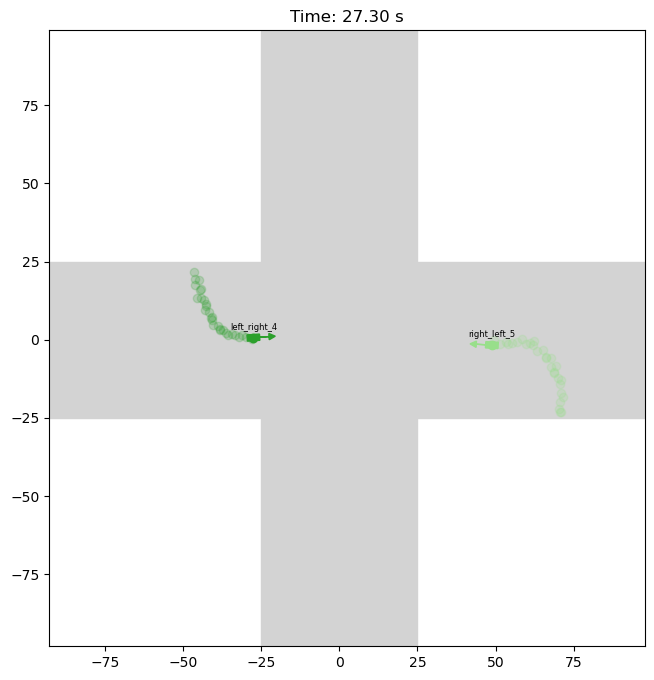

In [28]:
"""
visualize_with_prediction – debug build
---------------------------------------

Changes compared with your last version
1. update_angle → update_yaw_dataset: angle is added in *world* space,
   then converted back to the dataset convention (0 rad = +Y).
2. draw_yaw = yaw_dataset + π/2  (the dataset → world shift).
3. x_next, y_next are taken directly from the model output.
4. Plenty of DEBUG lines – switch off with debug=False.
"""

import os, datetime
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch_geometric.data import Data
from tqdm import tqdm


# ───────────────────────── helpers ──────────────────────────

def rotation_matrix_back(yaw_ds: float) -> torch.Tensor:
    """
    Undo the model’s ego-frame rotation.
    Dataset yaw 0 rad faces +Y, so the matrix starts with −π/2.
    """
    rot = np.array([[np.cos(-np.pi / 2 + yaw_ds), -np.sin(-np.pi / 2 + yaw_ds)],
                    [np.sin(-np.pi / 2 + yaw_ds),  np.cos(-np.pi / 2 + yaw_ds)]])
    return torch.tensor(rot, dtype=torch.float32)


def build_data_for_track(track_rows, device):
    """Return a one-frame PyG Data object [x, y, v, yaw, intent*3]."""
    tid = track_rows[0]['TRACK_ID']
    if 'left' in tid:
        intent = [1, 0, 0]
    elif 'right' in tid:
        intent = [0, 1, 0]
    else:
        intent = [0, 0, 1]

    feats = [[r['X'], r['Y'], r['speed'], r['yaw'], *intent]
             for r in track_rows]

    x = torch.as_tensor(feats, dtype=torch.float32, device=device)
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
    return Data(x=x, edge_index=edge_index)


def update_yaw_dataset(prev_yaw_ds, p1, p2, p3):
    """
    Add the steering angle (measured in *world* frame) to the previous
    dataset yaw and return the wrapped result in dataset convention.

    dataset yaw 0 rad  → +Y (north)
    world   yaw 0 rad  → +X (east)
    shift: yaw_world = yaw_dataset + π/2
    """
    # previous heading in world space
    yaw_w_prev = prev_yaw_ds + np.pi / 2

    # direction vectors
    v0 = np.subtract(p2, p1)
    v1 = np.subtract(p3, p2)

    # steering angle
    delta = np.arctan2(v1[1], v1[0]) - np.arctan2(v0[1], v0[0])
    yaw_w_new = yaw_w_prev + delta

    # back to dataset convention and wrap into [0, 2π)
    yaw_ds_new = np.mod(yaw_w_new - np.pi / 2, 2*np.pi)
    return yaw_ds_new


# ───────────────────────── main ──────────────────────────

def visualize_with_prediction(
        csv_folder: str,
        model_path: str,
        output_video_path: str = 'simulation.mp4',
        device: str = 'cpu',
        interval_ms: int = 100,
        duration_sec: int = None,
        background_path: str = None,
        show_progress: bool = True,
        debug: bool = True):

    # ---------- read data ----------
    all_csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not all_csvs:
        raise FileNotFoundError(f'No CSV files found in {csv_folder}')

    df = (pd.concat(pd.read_csv(p) for p in all_csvs)
            .sort_values('TIMESTAMP'))
    df['yaw'] = np.deg2rad(df['yaw'])          # deg → rad

    timestamps = df['TIMESTAMP'].unique().tolist()
    if duration_sec is not None:
        max_frames = min(len(timestamps), int(duration_sec*1000/interval_ms))
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # ---------- colours & limits ----------
    track_ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(track_ids)}

    x_lo, x_hi = df['X'].min()-10, df['X'].max()+10
    y_lo, y_hi = df['Y'].min()-10, df['Y'].max()+10
    bg_img = plt.imread(background_path) if background_path else None

    # ---------- load model ----------
    model = GNN_mtl_gnn(hidden_channels=128).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ---------- figure ----------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    last_state = {}        # TRACK_ID → dict(row-like)

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_title(f'Time: {ts:.2f} s')

        if bg_img is not None:
            ax.imshow(bg_img, extent=[x_lo, x_hi, y_lo, y_hi],
                      origin='lower', cmap='gray', alpha=.6)
        else:
            road_w = 50
            ax.add_patch(plt.Rectangle((x_lo-20, -road_w/2),
                                       (x_hi-x_lo)+40, road_w,
                                       color='lightgray', zorder=0))
            ax.add_patch(plt.Rectangle((-road_w/2, y_lo-20),
                                       road_w, (y_hi-y_lo)+40,
                                       color='lightgray', zorder=0))

        for _, row in grouped.get_group(ts).iterrows():
            tid = row['TRACK_ID']
            col = colours[tid]

            # ---- first appearance ---------------------------------
            if tid not in last_state:
                last_state[tid] = row
                ax.plot(row['X'], row['Y'], 'o', color=col)
                ax.text(row['X'], row['Y']+2.5, str(tid), fontsize=6,
                        ha='center', zorder=3)
                if debug:
                    print(f'DEBUG new {tid} at ({row["X"]:.2f},{row["Y"]:.2f})')
                continue

            # ---- predict one step --------------------------------
            prev = last_state[tid]
            data = build_data_for_track([prev], device)
            with torch.no_grad():
                out = model(data.x[:, [0, 1, 4, 5, 6]], data.edge_index)
            out = out.reshape(-1, 30, 2).permute(0, 2, 1)

            yaw_prev_ds = prev['yaw']
            rot = rotation_matrix_back(yaw_prev_ds).to(out.device)
            out = torch.bmm(rot.unsqueeze(0), out).permute(0, 2, 1)
            out += data.x[:, [0, 1]].unsqueeze(1)

            x_pred, y_pred = out[0, 0].cpu().numpy()
            x_next, y_next = out[0, 1].cpu().numpy()

            if debug:
                print(f'DEBUG {tid} ts={ts:.2f} '
                      f'prev=({prev["X"]:.2f},{prev["Y"]:.2f}) '
                      f'pred=({x_pred:.2f},{y_pred:.2f}) '
                      f'next=({x_next:.2f},{y_next:.2f}) '
                      f'yaw_ds_prev={yaw_prev_ds:.2f}')

            # ---- yaw update --------------------------------------
            p1 = (prev['X'], prev['Y'])
            p2 = (x_pred, y_pred)
            p3 = (x_next, y_next)
            yaw_ds_new = update_yaw_dataset(yaw_prev_ds, p1, p2, p3)

            # world-space heading for drawing
            draw_yaw = yaw_ds_new + np.pi / 2

            # ---- plot current point ------------------------------
            ax.plot(x_pred, y_pred, 'o', color=col)
            ax.arrow(x_pred, y_pred,
                     5*np.cos(draw_yaw), 5*np.sin(draw_yaw),
                     head_width=2, head_length=2, fc=col, ec=col)

            # future dots
            col_fut = (col[0], col[1], col[2], 0.2)
            ax.plot(out[0, 1:, 0].cpu(), out[0, 1:, 1].cpu(),
                    'o', color=col_fut, alpha=0.2)

            # simple rectangle
            car_len, car_w = 4, 2
            rect = plt.Rectangle((x_pred - car_len/2, y_pred - car_w/2),
                                 car_len, car_w, color=col, zorder=1)
            trans = (plt.matplotlib.transforms.Affine2D()
                     .rotate_around(x_pred, y_pred, draw_yaw) + ax.transData)
            rect.set_transform(trans)
            ax.add_patch(rect)
            ax.text(x_pred, y_pred+2.5, str(tid), fontsize=6,
                    ha='center', zorder=3)

            # ---- store state -------------------------------------
            last_state[tid] = prev.copy()
            last_state[tid]['X'] = x_pred
            last_state[tid]['Y'] = y_pred
            last_state[tid]['yaw'] = yaw_ds_new

        return []


    # ---------- animation ----------
    Path(output_video_path).parent.mkdir(parents=True, exist_ok=True)
    ani = animation.FuncAnimation(fig, update, frames=len(timestamps),
                                  blit=False, interval=interval_ms,
                                  repeat=False)

    # ---------- progress bar ----------
    bar = tqdm(total=len(timestamps), disable=not show_progress,
               desc='render')

    def _progress(frame, total):
        if frame > bar.n:
            bar.update(frame - bar.n)

    ani.save(output_video_path, writer='ffmpeg',
             fps=1000//interval_ms, progress_callback=_progress)
    bar.close()
    print('Video saved to', output_video_path)


# ──────────────────── example call ─────────────────────
if __name__ == '__main__':
    csv_folder = 'csv/train_1k_simple_separate_10m'
    model_path = ('trained_params_archive/sumo_with_mpc_online_control/'
                  'model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    out_vid = f'output/{datetime.datetime.now():%Y%m%d_%H%M}_anim.mp4'

    visualize_with_prediction(
        csv_folder=csv_folder,
        model_path=model_path,
        output_video_path=out_vid,
        device=device,
        interval_ms=100,
        duration_sec=20,
        background_path=None,
        show_progress=True,
        debug=True     # turn off once things look good
    )
